In [2]:
import pandas as pd
import numpy as np
import pandas as pd
from pyarrow import Table
import pyarrow.dataset as ds
import pyarrow.compute as pc
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
from source import *
from pathlib import Path
from itertools import cycle
import scienceplots

plt.style.use(['science','ieee', 'grid'])
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
plt.rcParams["figure.figsize"] = (12/1.5, 6/1.5) 


In [3]:
sig = ds.dataset(list(Path(f"sig_data/").glob("*.parquet")), format="parquet")

In [4]:
bsbs = ds.dataset(list(Path(f"gen_data/").glob("bsbs*.parquet")), format="parquet")
nonbsbs = ds.dataset(list(Path(f"gen_data/").glob("nonbsbs*.parquet")), format="parquet")
uds = ds.dataset(list(Path(f"gen_data/").glob("uds*.parquet")), format="parquet")

In [5]:
scanner = bsbs.scanner(batch_size=100_000)
for batch in scanner.to_batches():
    table = Table.from_batches([batch])
    print(table.to_pandas().columns)
    break
del scanner

Index(['__experiment__', '__run__', '__event__', '__production__', 'pcm',
       'ecm', 'missedE', 'recM2_Ups', 'pmiss', 'cmpmiss', 'thetamiss',
       'cmthetamiss', 'fox', 'asymmetry', 'p0', 'theta_Bs', 'M0', 'recM2_Bs',
       'idec0', 'idec1', 'is0', 'N_KL', 'Miss_id_0', 'Miss_id_1', 'Bs_lik',
       'N_KS', 'theta_tau_0', 'p_tau_0', 'theta_tau_1', 'p_tau_1', 'tau_d_0_0',
       'tau_d_1_0', 'tau_last_z_0', 'tau_last_r_0', 'tau_last_z_1',
       'tau_last_r_1', 'Istau0', 'Istau1', 'Chi_sq_0', 'Chi_sq_1', 'dr0',
       'dr1', 'totalEnergyMC', 'E_gamma_in_ROE', 'correct_nu_0',
       'correct_nu_1', 'correct_gamma_0', 'correct_gamma_1', 'lost_0',
       'lost_1', 'PID_self_vs_0_tau0', 'PID_self_vs_1_tau0',
       'PID_self_vs_2_tau0', 'PID_self_vs_4_tau0', 'PID_self_vs_0_tau1',
       'PID_self_vs_1_tau1', 'PID_self_vs_2_tau1', 'PID_self_vs_4_tau1'],
      dtype='object')


In [6]:
decay_mod_tau = ["$e^+ \\nu_e \\bar \\nu_\\tau$", "$\mu^+ \\nu_\\mu \\bar \\nu_\\tau$", "$\\pi^+ \\bar \\nu_\\tau$", "$\\rho^+ (\\pi^+ \\pi^0) \\bar \\nu_\\tau$", "$\\pi^+ \\pi^+ \\pi^- \\bar \\nu_\\tau$", "$\\rho^+ (\\pi^+ \\gamma) \\bar \\nu_\\tau$"]
mask = (pc.field("E_gamma_in_ROE") < 1.2) & (pc.field("Bs_lik") > 0.0012)
mask_M = (pc.field("M0") > 5.347) &  (pc.field("M0") < 5.387) 
mask1 = (pc.field("E_gamma_in_ROE") < 1.2) & (pc.field("is0") == 1) & (pc.field("Bs_lik") > 0.0012) &  (pc.field("M0") > 5.347) &  (pc.field("M0") < 5.387) 
mask0 = (pc.field("E_gamma_in_ROE") < 1.2) & (pc.field("is0") == 0) & (pc.field("Bs_lik") > 0.0012) &  (pc.field("M0") > 5.347) &  (pc.field("M0") < 5.387)
mask_is1 = pc.field("correct_nu_0") & pc.field("correct_nu_1") & pc.field("correct_gamma_0") & pc.field("correct_gamma_1") & pc.field("lost_0") & pc.field("lost_1") & pc.field("Miss_id_0") & pc.field("Miss_id_1")
mask_is0 = pc.field("is0") == 1
mask_lep = ((pc.field("idec0") == 0) | (pc.field("idec0") == 1)) & ((pc.field("idec1") == 0) | (pc.field("idec1") == 1))
mask_miss_id = pc.field("Miss_id_0") & pc.field("Miss_id_1")
mask_lost_Kpi = pc.field("lost_0") & pc.field("lost_1")
mask_KS_veto = (pc.field("N_KS") == 0) & (pc.field("N_KL") == 0)

<>:1: SyntaxWarning: invalid escape sequence '\m'
<>:1: SyntaxWarning: invalid escape sequence '\m'
C:\Users\matve\AppData\Local\Temp\ipykernel_16024\1173690368.py:1: SyntaxWarning: invalid escape sequence '\m'
  decay_mod_tau = ["$e^+ \\nu_e \\bar \\nu_\\tau$", "$\mu^+ \\nu_\\mu \\bar \\nu_\\tau$", "$\\pi^+ \\bar \\nu_\\tau$", "$\\rho^+ (\\pi^+ \\pi^0) \\bar \\nu_\\tau$", "$\\pi^+ \\pi^+ \\pi^- \\bar \\nu_\\tau$", "$\\rho^+ (\\pi^+ \\gamma) \\bar \\nu_\\tau$"]


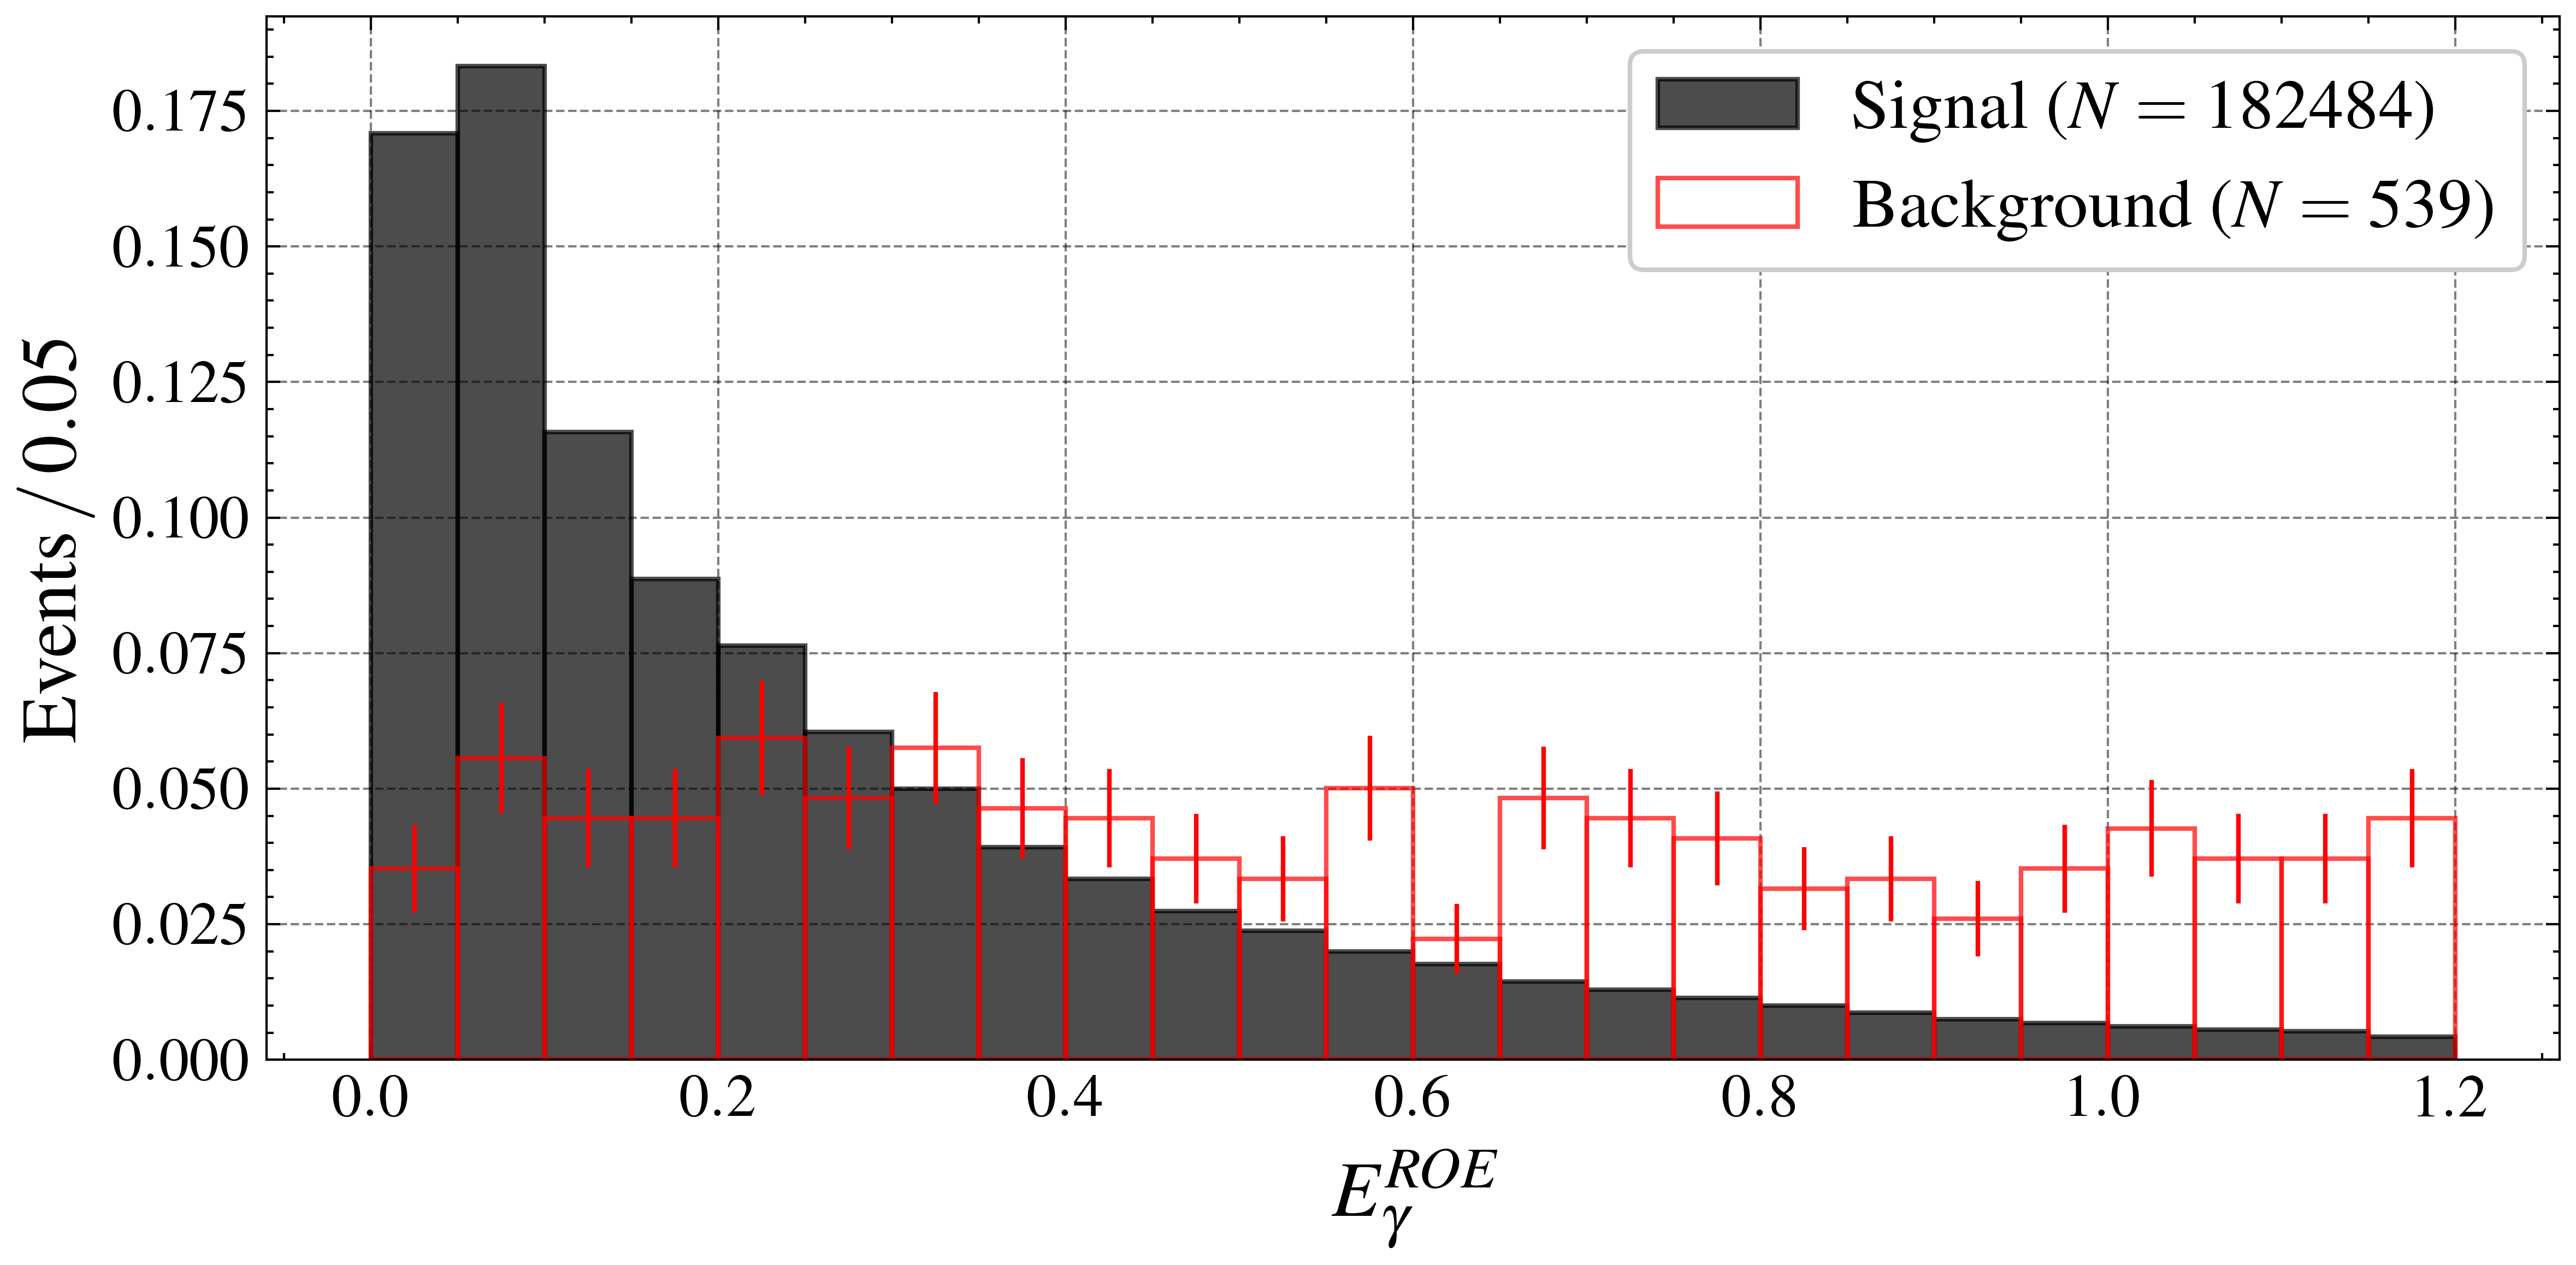

In [7]:
wbin = 0.05
a = 0
b = 1.2
bins = np.linspace(a, b, int((b-a)//wbin +2))

fig, ax = plt.subplots(1, figsize=(12/1.5, 6/1.5))


bin_centers_sig, counts_sig, N_sig = compute_histogram(
    sig, bins, "E_gamma_in_ROE",
    filter_mask=(mask_lep & (pc.field("is0") == 1)),
    norm=True, nanto=-1
) 
ax.bar(
    bin_centers_sig, counts_sig,
    width=wbin, align='center',
    alpha=0.7, linewidth=1,
    edgecolor=colors[0], color=colors[0], ecolor=colors[0],
    label=f"Signal ($N = {N_sig}$)",
)

bin_centers_bsbs, counts_bsbs, N_bsbs = compute_histogram(
    bsbs, bins, "E_gamma_in_ROE",
    filter_mask=(mask_lep & (pc.field("is0") == 1)),
    norm=True, nanto=-1
) 
ax.bar(
    bin_centers_bsbs, counts_bsbs,
    yerr=np.sqrt(counts_bsbs)/np.sqrt(N_bsbs),
    width=wbin, align='center',
    fill = False, alpha = 0.7, linewidth=1,
    edgecolor=colors[1], color=colors[1], ecolor=colors[1],
    label=f"Background ($N = {N_bsbs}$)"
)

ax.set_ylabel(f'$\\mathrm{{Events}}\\,/\\,{wbin}$')
ax.set_xlabel(r'$E_{\gamma}^{ROE}$')
ax.legend()

plt.tight_layout()
plt.show()


In [8]:
from xgboost import XGBClassifier
import json

In [9]:
model = XGBClassifier()
model.load_model("bdt_model.json")
with open("columns_and_fom.json", "r") as f:
    data_to_save = json.load(f)
columns = data_to_save["columns"]
FoM = data_to_save["FoM"]

In [10]:
v1 = get_values(bsbs, columns + ['E_gamma_in_ROE'], filter_mask=(mask & mask_lep & (pc.field("is0") == 1)))
v2 = get_values(nonbsbs, columns + ['E_gamma_in_ROE'], filter_mask=(mask & mask_lep & (pc.field("is0") == 1)))
v3 = get_values(uds, columns + ['E_gamma_in_ROE'], filter_mask=(mask & mask_lep & (pc.field("is0") == 1)))
v4a = get_values(uds, columns + ['E_gamma_in_ROE'], filter_mask=(mask & mask_lep & (pc.field("is0") == 0)))
v4b = get_values(nonbsbs, columns + ['E_gamma_in_ROE'], filter_mask=(mask & mask_lep & (pc.field("is0") == 0)))
v4c = get_values(bsbs, columns + ['E_gamma_in_ROE'], filter_mask=(mask & mask_lep & (pc.field("is0") == 0)))

v4 = pd.concat([v4a, v4b, v4c], ignore_index=True)

v1["marker"] = 1  # $B_S \to D(\ell \nu)\ell \nu$
v2["marker"] = 2  # nonbsbs
v3["marker"] = 3  # continuum
v4["marker"] = 4  # FEI missID

data = pd.concat([v1, v2, v3, v4], ignore_index=True)


Total data size: 0.02 MB
Total data size: 0.00 MB
Total data size: 0.00 MB
Total data size: 0.00 MB
Total data size: 0.00 MB
Total data size: 0.01 MB


<>:28: SyntaxWarning: invalid escape sequence '\g'
<>:28: SyntaxWarning: invalid escape sequence '\g'
C:\Users\matve\AppData\Local\Temp\ipykernel_16024\1529370032.py:28: SyntaxWarning: invalid escape sequence '\g'
  plt.title("PDF of $E_\gamma^{\\mathrm{ROE}}$")


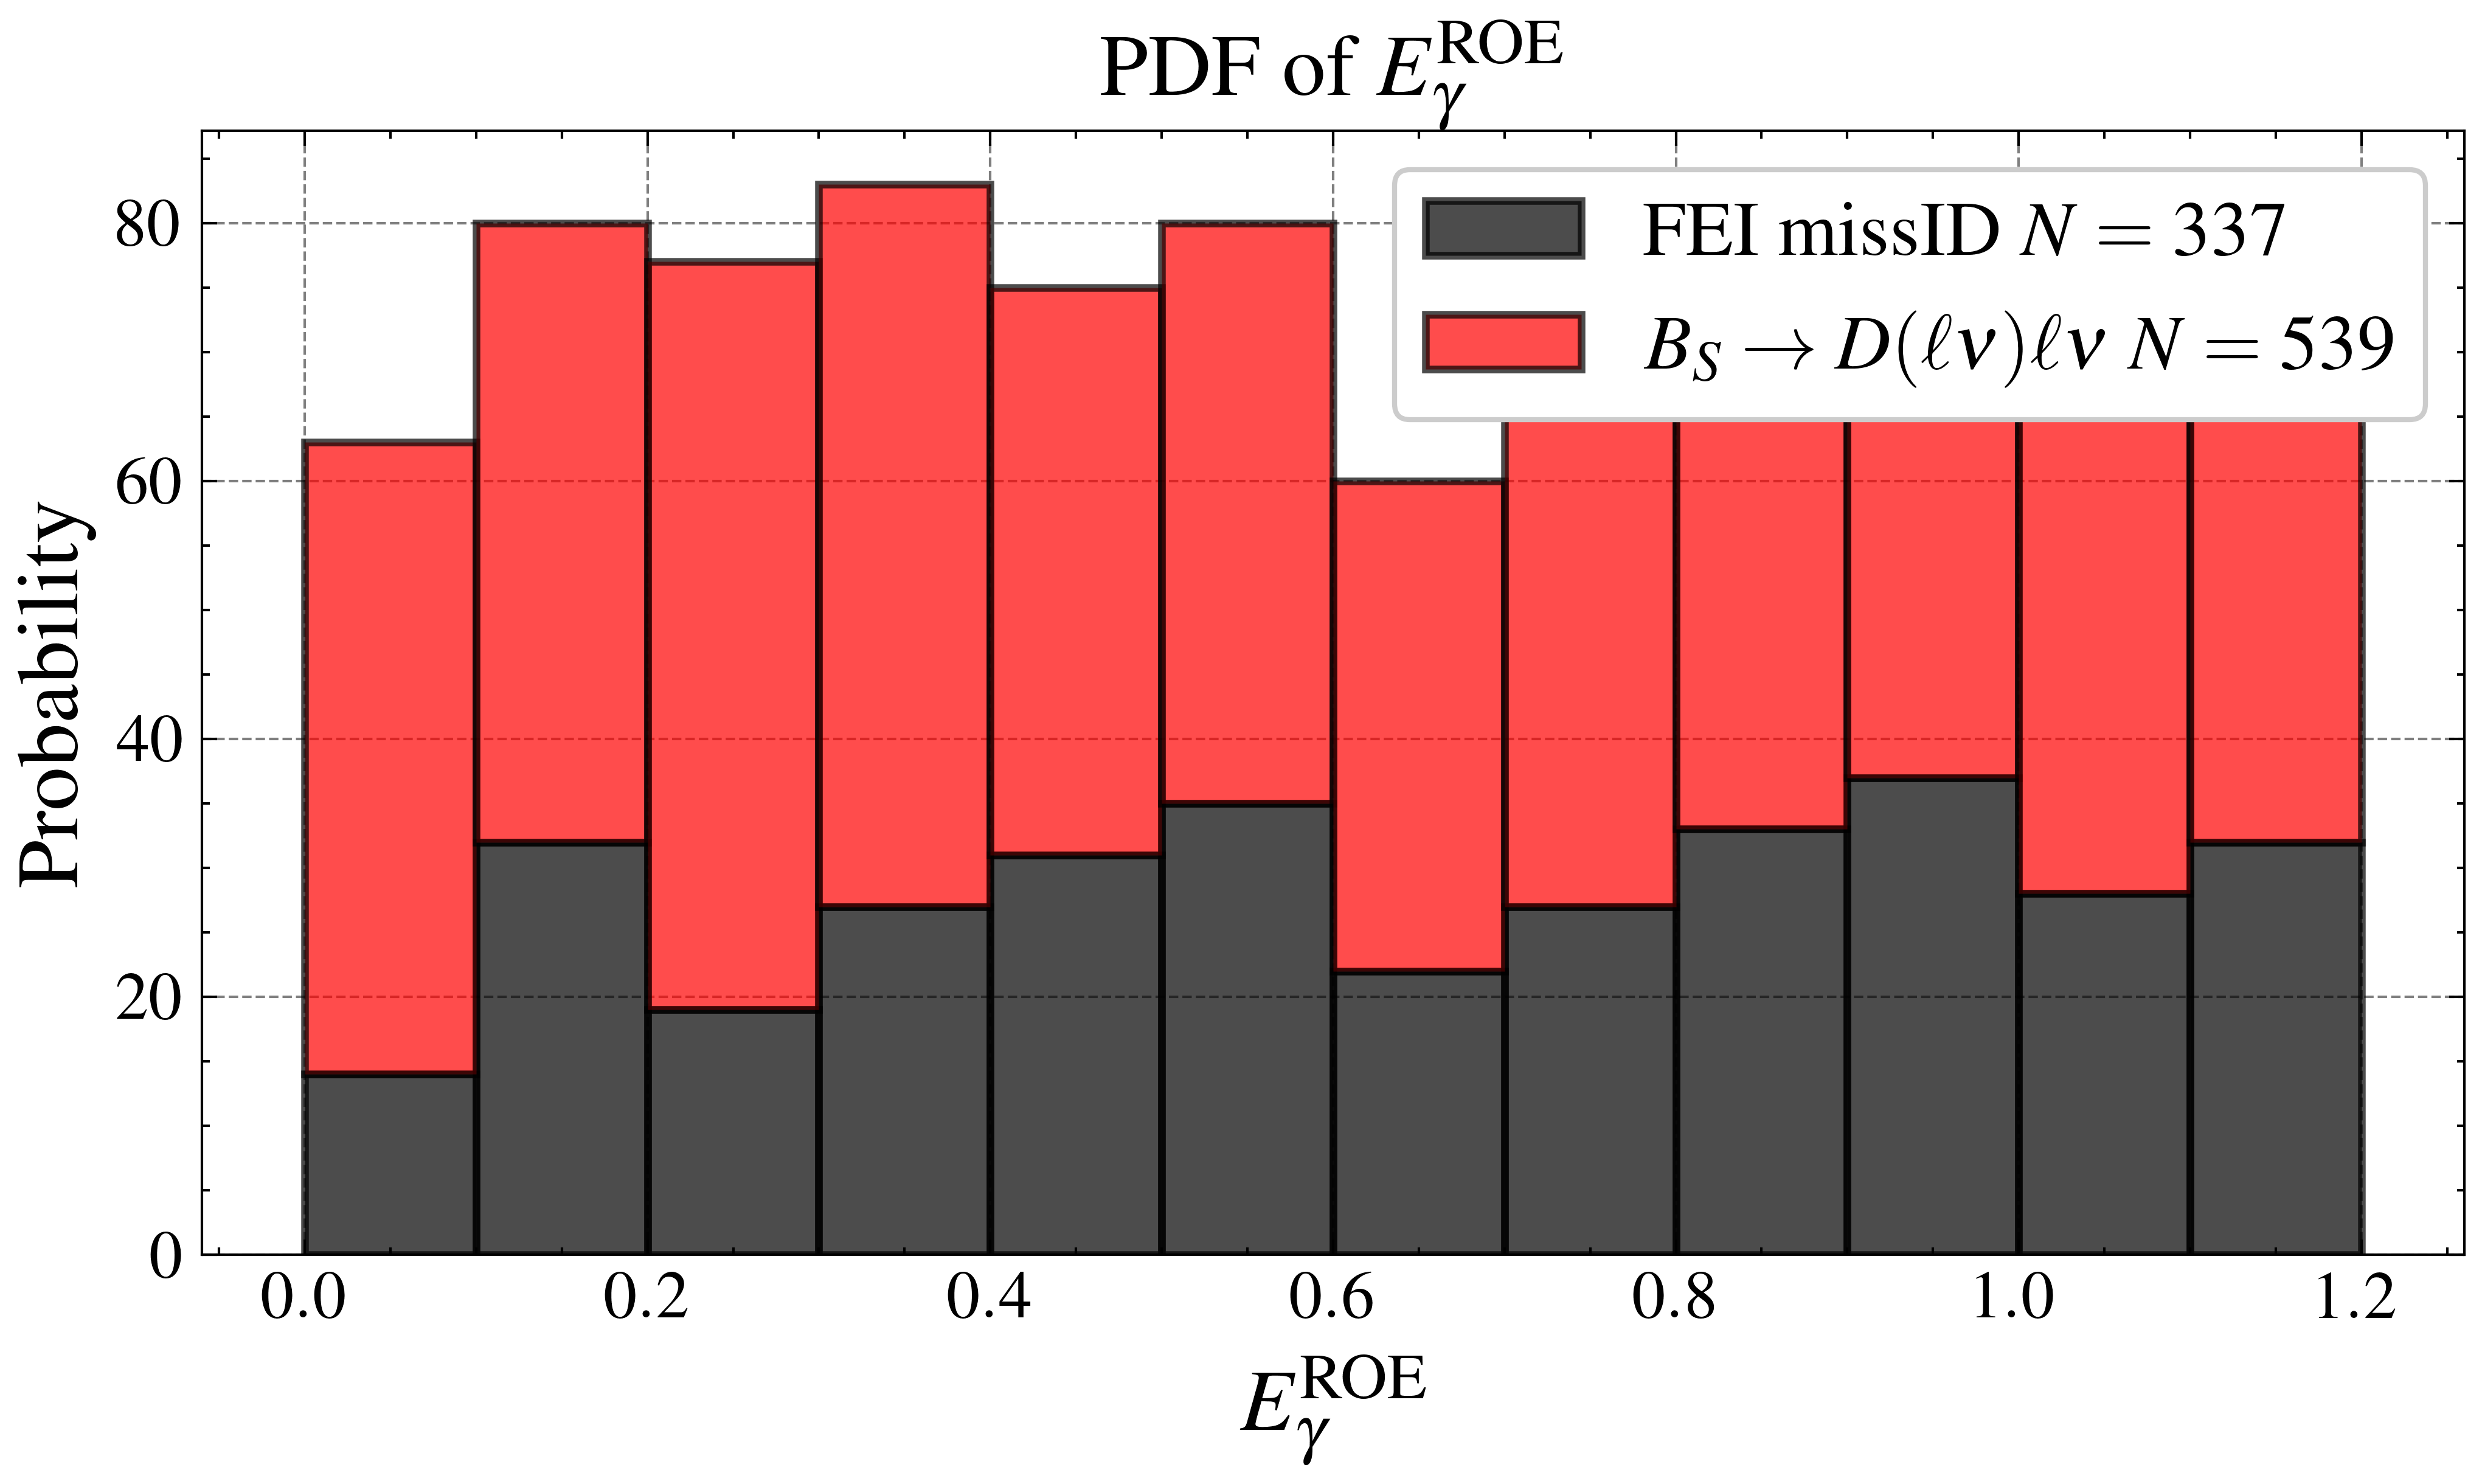

In [11]:
wbin = 0.1
a = 0
b = 1.2
bins = np.linspace(a, b, int((b - a) // wbin) + 2)

# Словарь отображения маркеров в подписи
marker_labels = {
    1: r"$B_S \to D(\ell \nu)\ell \nu$",
    2: "nonbsbs",
    3: "Continuum",
    4: "FEI missID"
}

# Извлекаем данные и группируем
stack_data = []
stack_labels = []
for marker in sorted(data["marker"].unique(), key=lambda x: (data["marker"] == x).sum()):
    subset = data[data["marker"] == marker]["E_gamma_in_ROE"]
    stack_data.append(subset)
    stack_labels.append(f"{marker_labels[marker]} $N = {len(subset)}$")

# Рисуем
plt.hist(stack_data, bins=bins, stacked=True, alpha=0.7, edgecolor="black", linewidth=1.5, label=stack_labels)


plt.xlabel(r"$E_\gamma^{\mathrm{ROE}}$")
plt.ylabel("Probability")
plt.title("PDF of $E_\gamma^{\\mathrm{ROE}}$")
plt.grid(True)
plt.legend()
plt.show()

In [12]:
def get_pdf(aaaa, a, b, num_points=1000, smooth=1e-1):
    from scipy.interpolate import UnivariateSpline, interp1d

    """
    Возвращает кортеж: xs, pdf(xs), и pdf_function(x)
    """
    # Подготовка
    xs = np.linspace(a, b, num_points)
    data_sorted = np.sort(aaaa[(aaaa >= a) & (aaaa <= b)])
    
    if len(data_sorted) == 0:
        raise ValueError("No data in the specified range.")

    # Кумулятивная функция
    cdf = np.searchsorted(data_sorted, xs, side='right') / len(data_sorted)

    # Сглаживание CDF
    spline = UnivariateSpline(xs, cdf, s=smooth)
    smooth_pdf = spline.derivative()(xs)

    # Интерполяция полученной PDF в виде функции
    pdf_function = interp1d(xs, smooth_pdf, bounds_error=False, fill_value=0.0)

    return xs, smooth_pdf, pdf_function


In [13]:

def get_pdf(data, a, b, num_points1=1000, num_points2=200):
    from scipy.interpolate import Akima1DInterpolator
    from scipy.integrate import quad

    data_sorted = np.sort(data[(data >= a) & (data <= b)])
    if len(data_sorted) == 0:
        raise ValueError("No data in the specified range.")

    xs_cdf = np.linspace(a, b, num_points1)
    cdf = np.searchsorted(data_sorted, xs_cdf, side='right') / len(data_sorted)

    cdf_interp = Akima1DInterpolator(xs_cdf, cdf)

    xs_pdf = np.linspace(a, b, num_points2)
    dcdf = np.gradient(cdf_interp(xs_pdf), xs_pdf)
    pdf_vals = np.clip(dcdf, 0, None)
    dx = np.diff(xs_pdf)
    dx = np.append(dx, dx[-1])
    integral = np.sum(pdf_vals * dx)
    pdf_vals /= integral

    pdf_function_raw = Akima1DInterpolator(xs_pdf, pdf_vals)
    integral_func, _ = quad(pdf_function_raw, a, b, limit=200)
    pdf_function = lambda x: np.clip(pdf_function_raw(x), 0, None) / integral_func

    return xs_pdf, pdf_vals, pdf_function


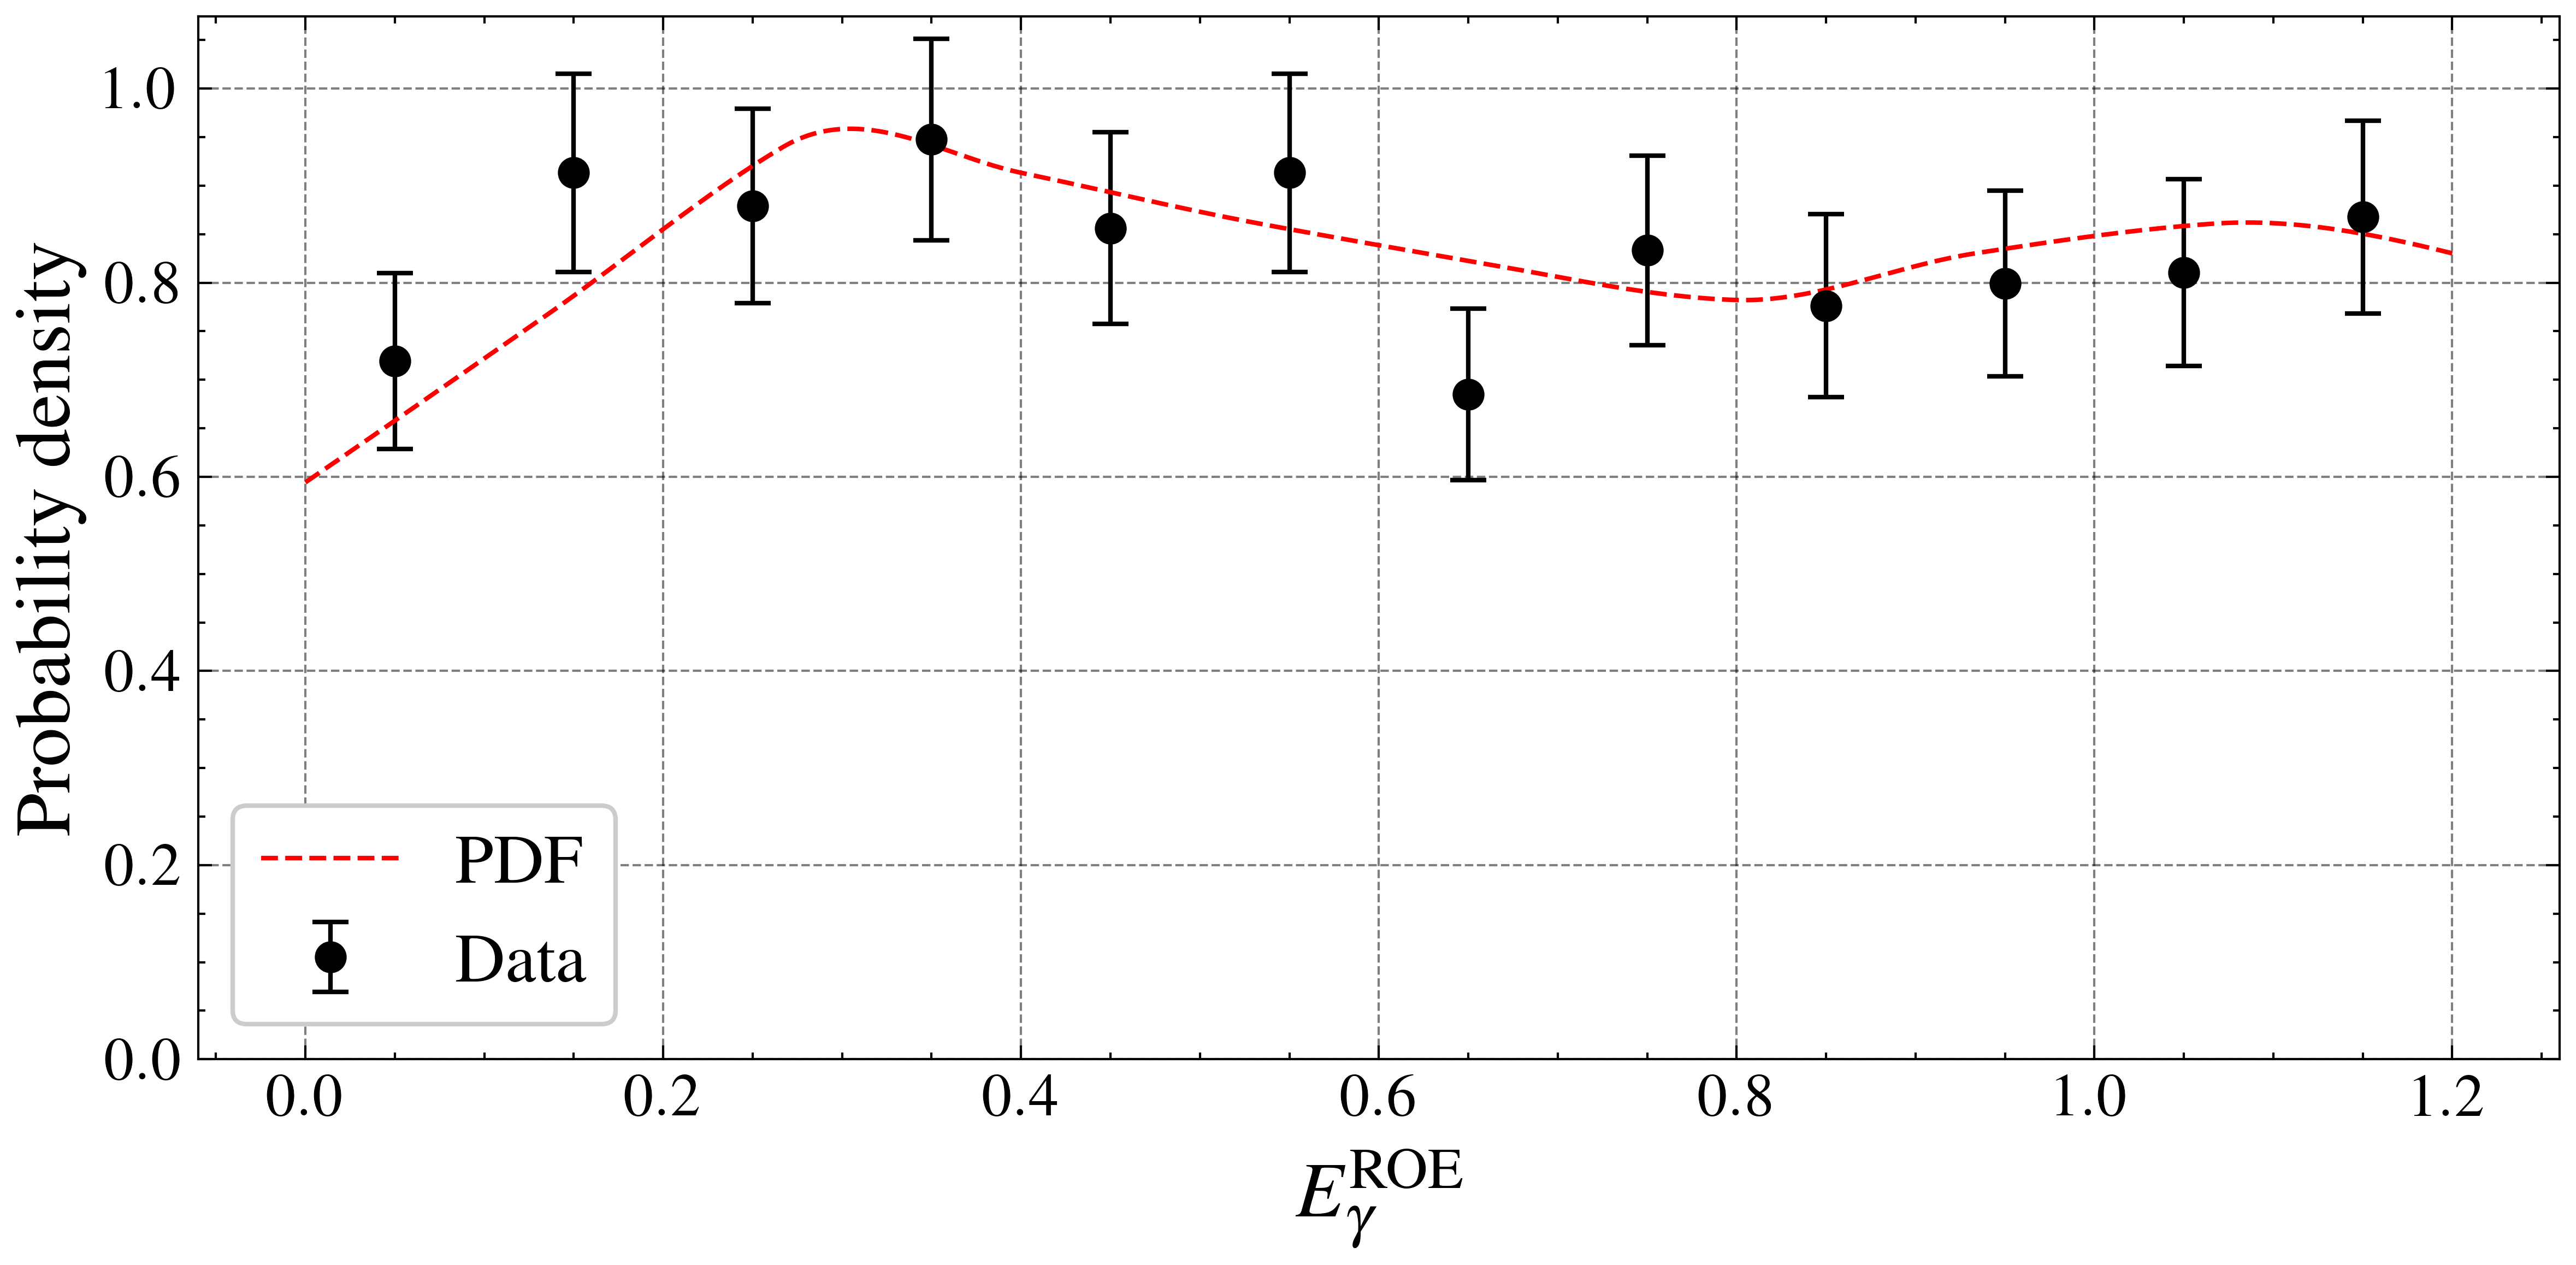

In [14]:

wbin = 0.1
a, b = 0, 1.2
bins = np.linspace(a, b, int((b - a) // wbin) + 2)

x_centers, pdf, dg_pdf = get_pdf(data["E_gamma_in_ROE"], a=a, b=b, num_points1=1000, num_points2=10)

all_values = data["E_gamma_in_ROE"]

fig, ax = plt.subplots(1, figsize=(12/1.5, 6/1.5))

errorhist(all_values, bins=bins, err_func=np.sqrt, fmt='o', axs=ax, density=True, capsize=4, label="Data")

ax.plot(np.linspace(a, b, 1000), dg_pdf(np.linspace(a, b, 1000)), label="PDF")

ax.set_xlabel(r"$E_\gamma^{\mathrm{ROE}}$")
ax.set_ylabel("Probability density")
ax.set_ylim(0)
ax.legend()
plt.tight_layout()
plt.show()


In [15]:
X_new = data[columns]

bdt_scores = model.predict_proba(X_new)[:, 1] 

data["bdt_score"] = bdt_scores

selected_mask = data["bdt_score"] > FoM

selected_data = data[selected_mask]


In [16]:
data[selected_mask]

,cmpmiss,cmthetamiss,missedE,fox,p_tau_0,theta_tau_0,p_tau_1,theta_tau_1,theta_Bs,E_gamma_in_ROE,marker,bdt_score
0,1.116524,-0.008195,2.617128,0.198424,0.824723,-0.649546,2.015624,0.213345,0.173775,0.567190,1,0.308977
2,0.662334,-0.084645,4.339268,0.380036,0.832427,-0.155344,0.295286,0.713910,-0.266737,0.563218,1,0.727100
3,1.600165,0.276673,3.642100,0.250823,0.469356,-0.859344,1.359632,0.728507,-0.338318,0.481992,1,0.597056
4,2.039244,-0.320993,3.317863,0.412634,0.269635,0.286947,1.888140,-0.415268,0.110046,0.459511,1,0.436714
5,1.731946,-0.420567,2.061337,0.368363,1.925831,0.093586,1.478052,-0.663775,0.152253,1.198673,1,0.404352
...,...,...,...,...,...,...,...,...,...,...,...,...
868,1.357659,0.125754,3.355999,0.215854,0.666436,0.727216,1.308607,-0.065387,-0.415231,0.958308,4,0.436107
869,1.294708,-0.491210,2.091300,0.228442,1.375406,0.203830,2.116240,-0.443096,0.054953,0.186126,4,0.438387
870,0.586751,0.467203,3.241649,0.184744,1.272342,-0.580709,0.980098,0.599306,0.876786,0.431791,4,0.430445
873,0.789222,0.015441,4.594697,0.266137,0.350021,0.410410,0.612822,-0.374051,0.176622,0.831355,4,0.356786


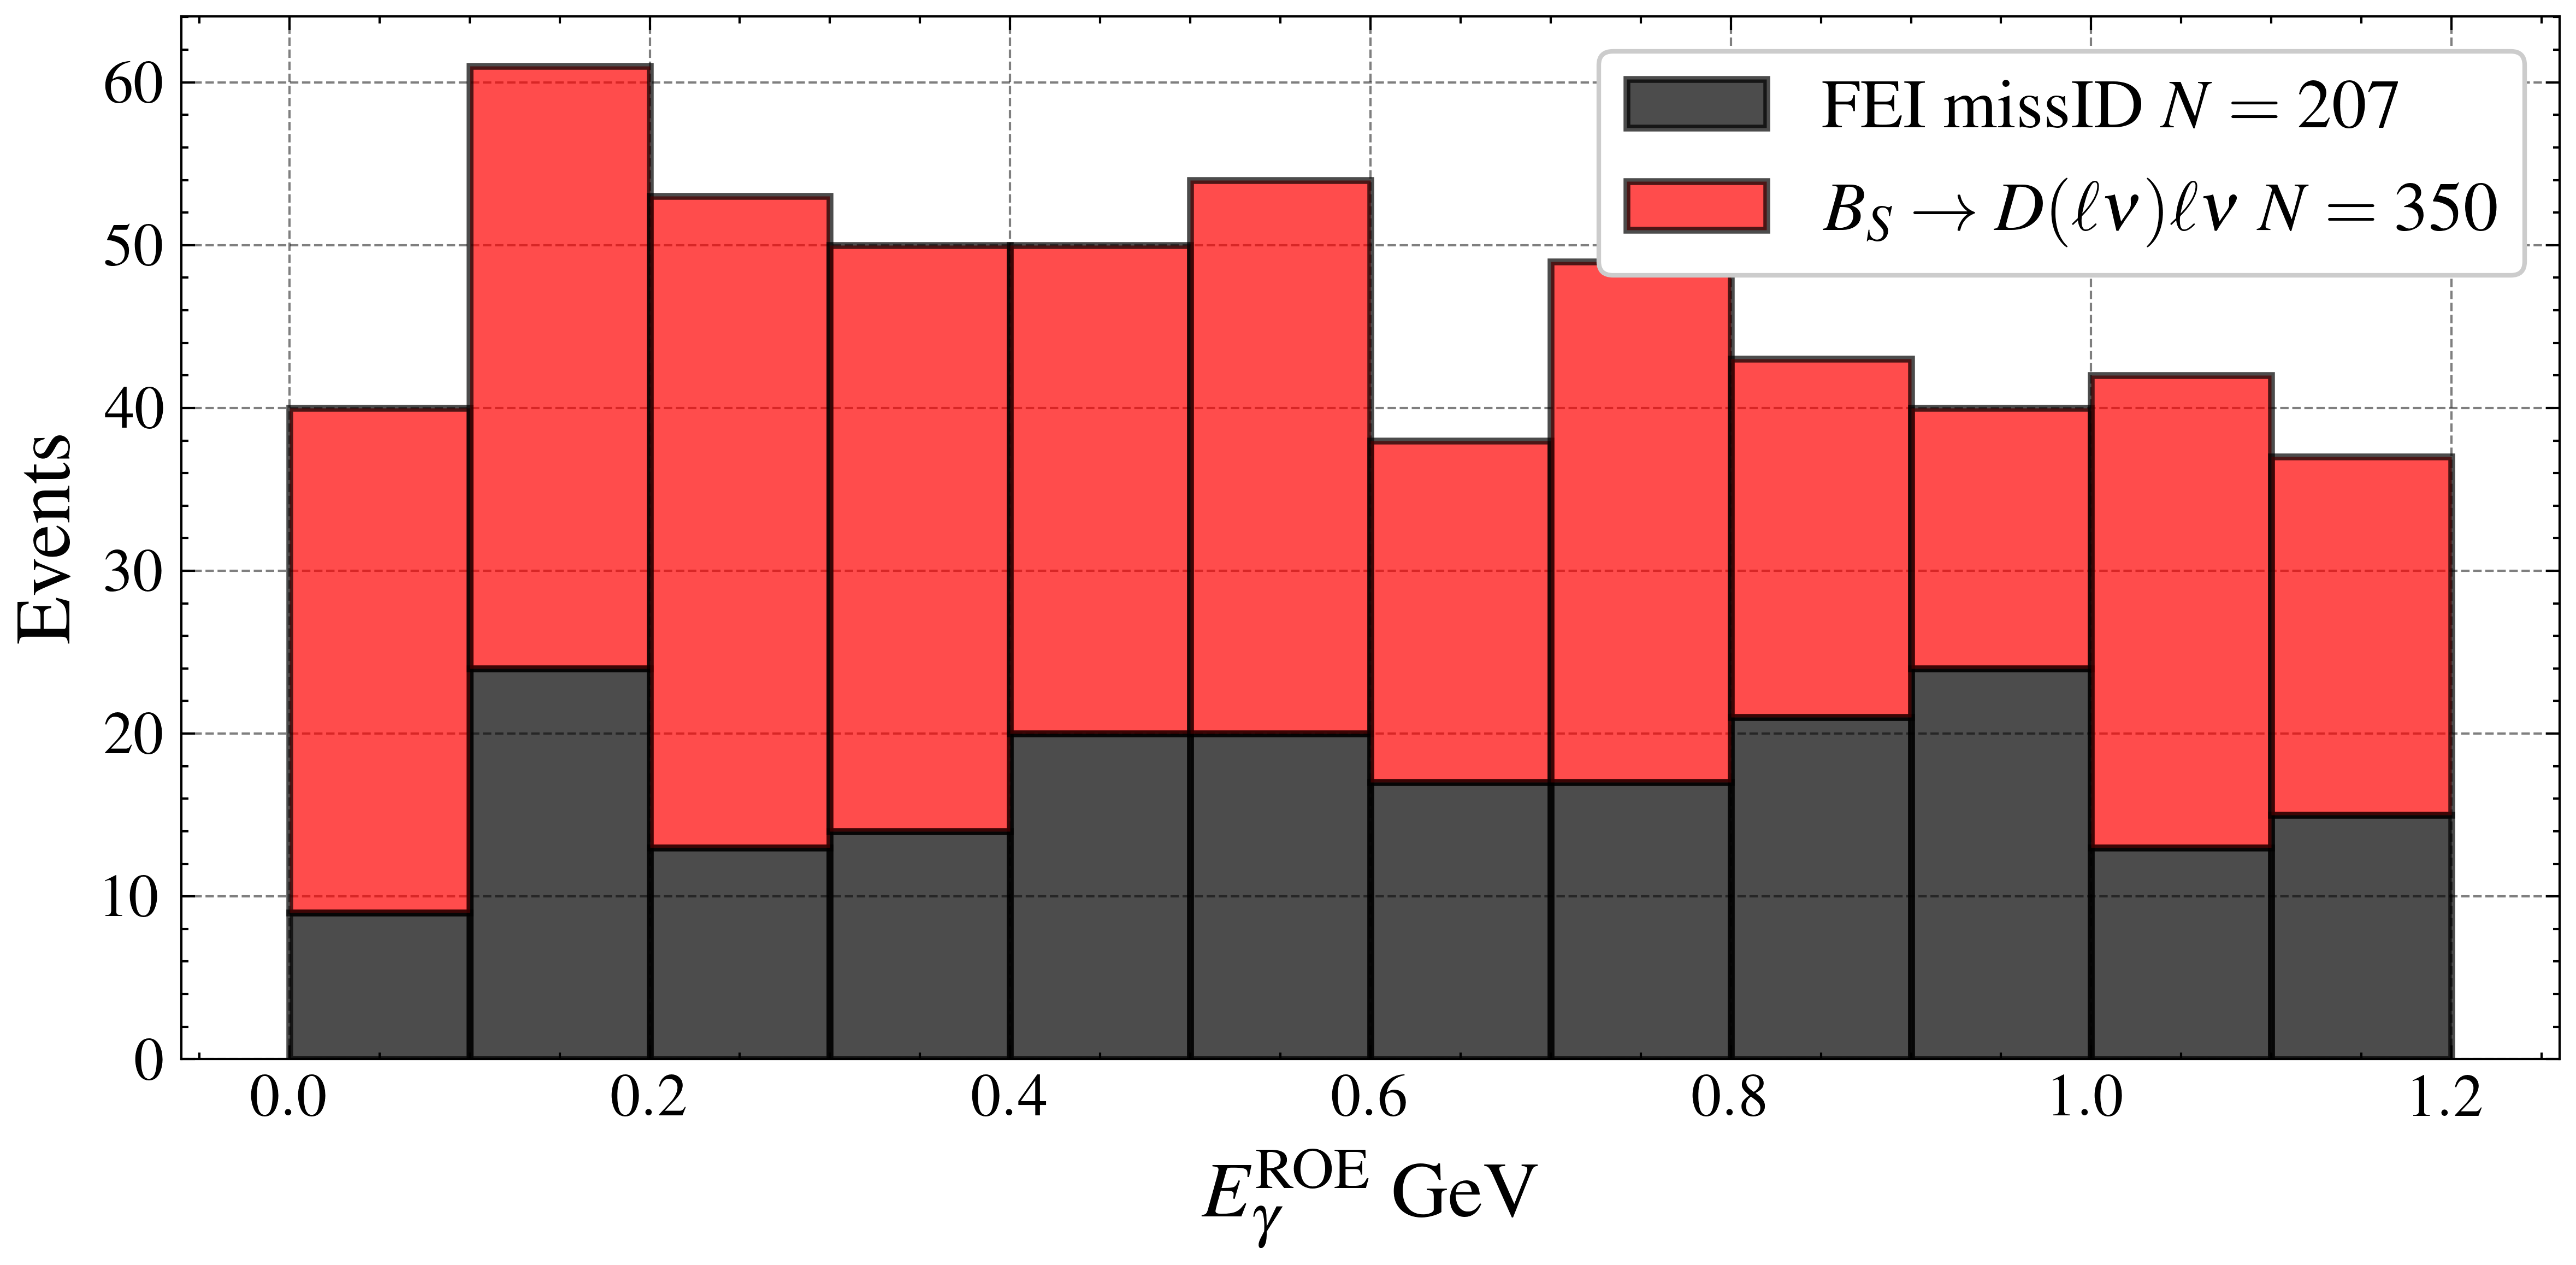

In [17]:
wbin = 0.1
a = 0
b = 1.2
bins = np.linspace(a, b, int((b - a) // wbin) + 2)

# Словарь отображения маркеров в подписи
marker_labels = {
    1: r"$B_S \to D(\ell \nu)\ell \nu$",
    2: "nonbsbs",
    3: "Continuum",
    4: "FEI missID"
}

# Извлекаем данные и группируем
stack_data = []
stack_labels = []
for marker in sorted(selected_data["marker"].unique(), key=lambda x: (selected_data["marker"] == x).sum()):
    subset = selected_data[selected_data["marker"] == marker]["E_gamma_in_ROE"]
    stack_data.append(subset)
    stack_labels.append(f"{marker_labels[marker]} $N = {len(subset)}$")

# Рисуем
plt.hist(stack_data, bins=bins, stacked=True, alpha=0.7, edgecolor="black", linewidth=1.5, label=stack_labels)

plt.xlabel(r"$E_{\gamma}^{\mathrm{ROE}}$ GeV")
plt.ylabel("Events")
plt.legend()
plt.tight_layout()
plt.show()


In [18]:
N_bg = len(stack_data[0])+len(stack_data[1])

In [19]:
def gen_toy(pdf_func, a, b, size=10000):
    samples = []
    ymax  = np.max(pdf_func(np.linspace(a, b, 1000)))
    while len(samples) < size:
        x_trial = np.random.uniform(a, b)
        y_trial = np.random.uniform(0, ymax)
        try:
            if y_trial <= pdf_func(x_trial):
                samples.append(x_trial)
        except: continue
    return np.array(samples)


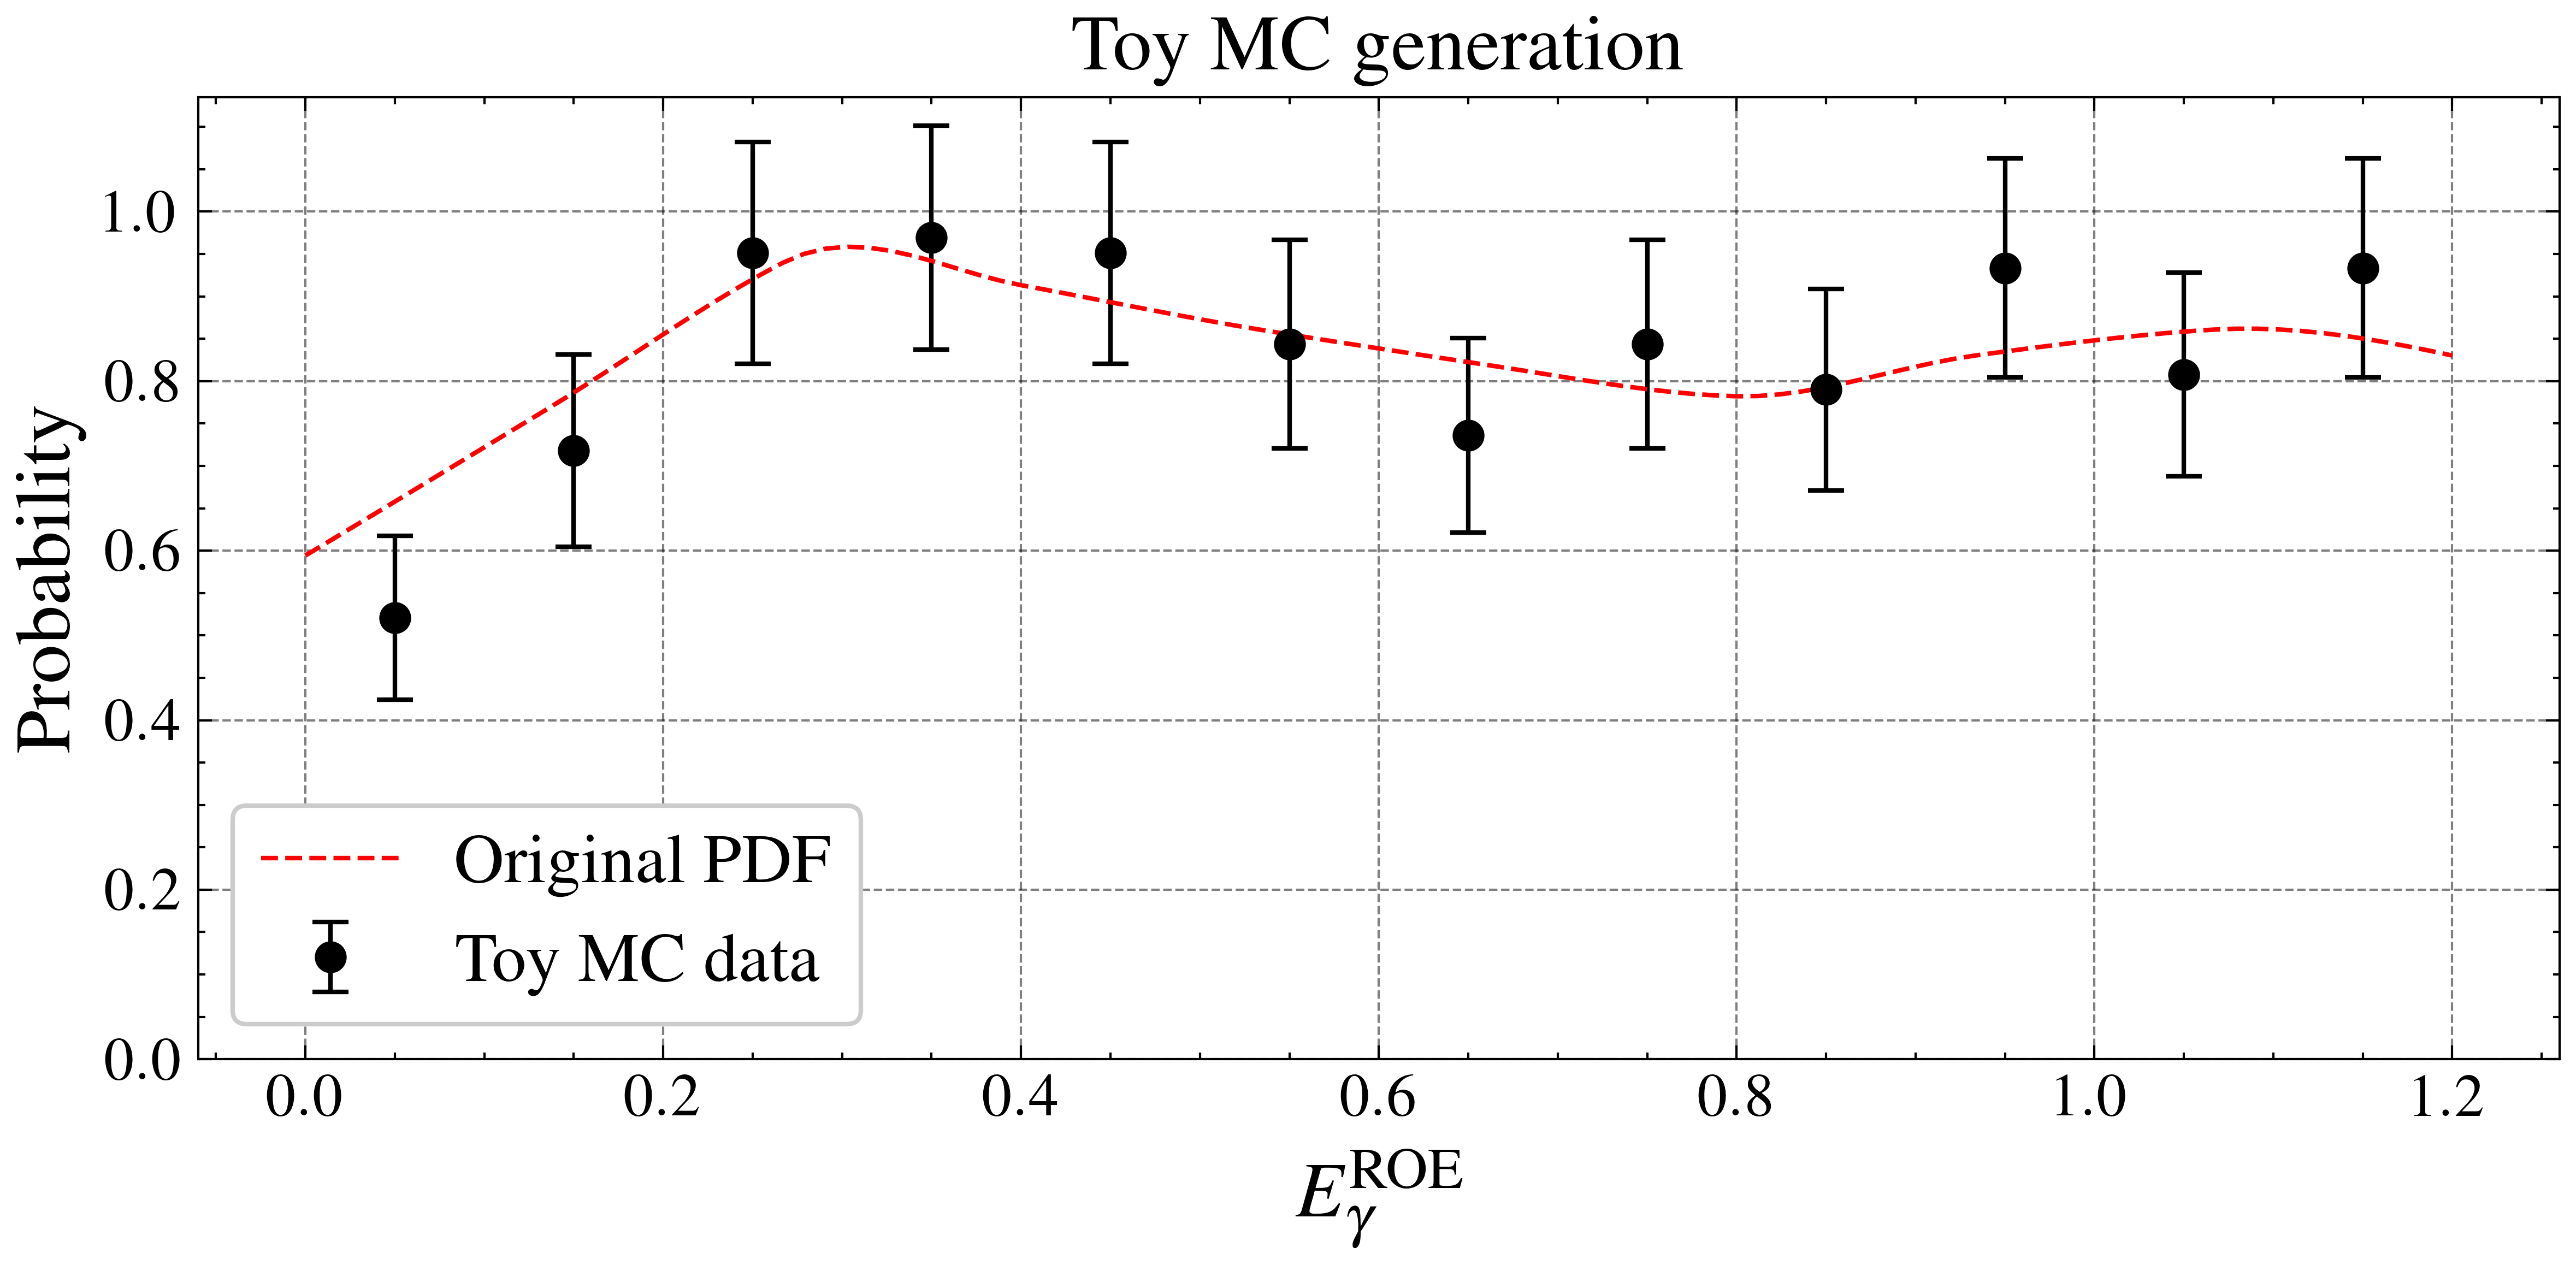

In [20]:
wbin = 0.1
a = 0
b = 1.2
bins = np.linspace(a, b, int((b-a)//wbin + 2))

samples = gen_toy(dg_pdf, a, b, N_bg)


errorhist(samples, bins=bins, err_func=np.sqrt, fmt='o', density=True, capsize=4, label="Toy MC data")

plt.plot(np.linspace(a, b, 100), dg_pdf(np.linspace(a, b, 100)), label="Original PDF")
plt.xlabel(r"$E_\gamma^{\mathrm{ROE}}$")
plt.ylabel("Probability")
plt.title("Toy MC generation")
plt.legend()
plt.ylim(0)
plt.grid(True)
plt.tight_layout()
plt.show()


In [21]:
def f_E_g_lep_gamma(x, *, lam, k, theta):
    from scipy.special import gamma
    x = np.where(x <= 0.000001, 0.0001, x)
    x = x*lam
    base = (1 / (gamma(k) * theta**k)) * x**(k - 1) * np.exp(-x / theta)
    return base
with open("sig_fit.json", "r") as f:
    rez0 = dict(json.load(f))
    del rez0["norm"]

In [22]:
def max_lik(f, x, args0, bounds=None, err_need=False):
    def df(*args):
        current_args = {k: v for k, v in zip(args0.keys(), args)}
        return -np.sum(np.log(f(x, **current_args)))

    from iminuit import Minuit
    minuit = Minuit(df, *[args0[k] for k in args0], name=list(args0.keys()))

    if bounds:
        for k, bnd in bounds.items():
            minuit.limits[k] = bnd

    minuit.migrad()

    rez = minuit.values.to_dict()
    errs = minuit.errors.to_dict() if err_need else None


    if err_need:
        return rez, errs
    return rez


In [23]:
f_fit = lambda x, *, A: f_E_g_lep_gamma(x, **rez0)/np.trapz(f_E_g_lep_gamma(np.linspace(0, 1.2, 1000), **rez0), np.linspace(0, 1.2, 1000)) * np.abs(A) + dg_pdf(x) * np.abs(1 - A) 

C:\Users\matve\AppData\Local\Temp\ipykernel_16024\2932709250.py:1: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  f_fit = lambda x, *, A: f_E_g_lep_gamma(x, **rez0)/np.trapz(f_E_g_lep_gamma(np.linspace(0, 1.2, 1000), **rez0), np.linspace(0, 1.2, 1000)) * np.abs(A) + dg_pdf(x) * np.abs(1 - A)


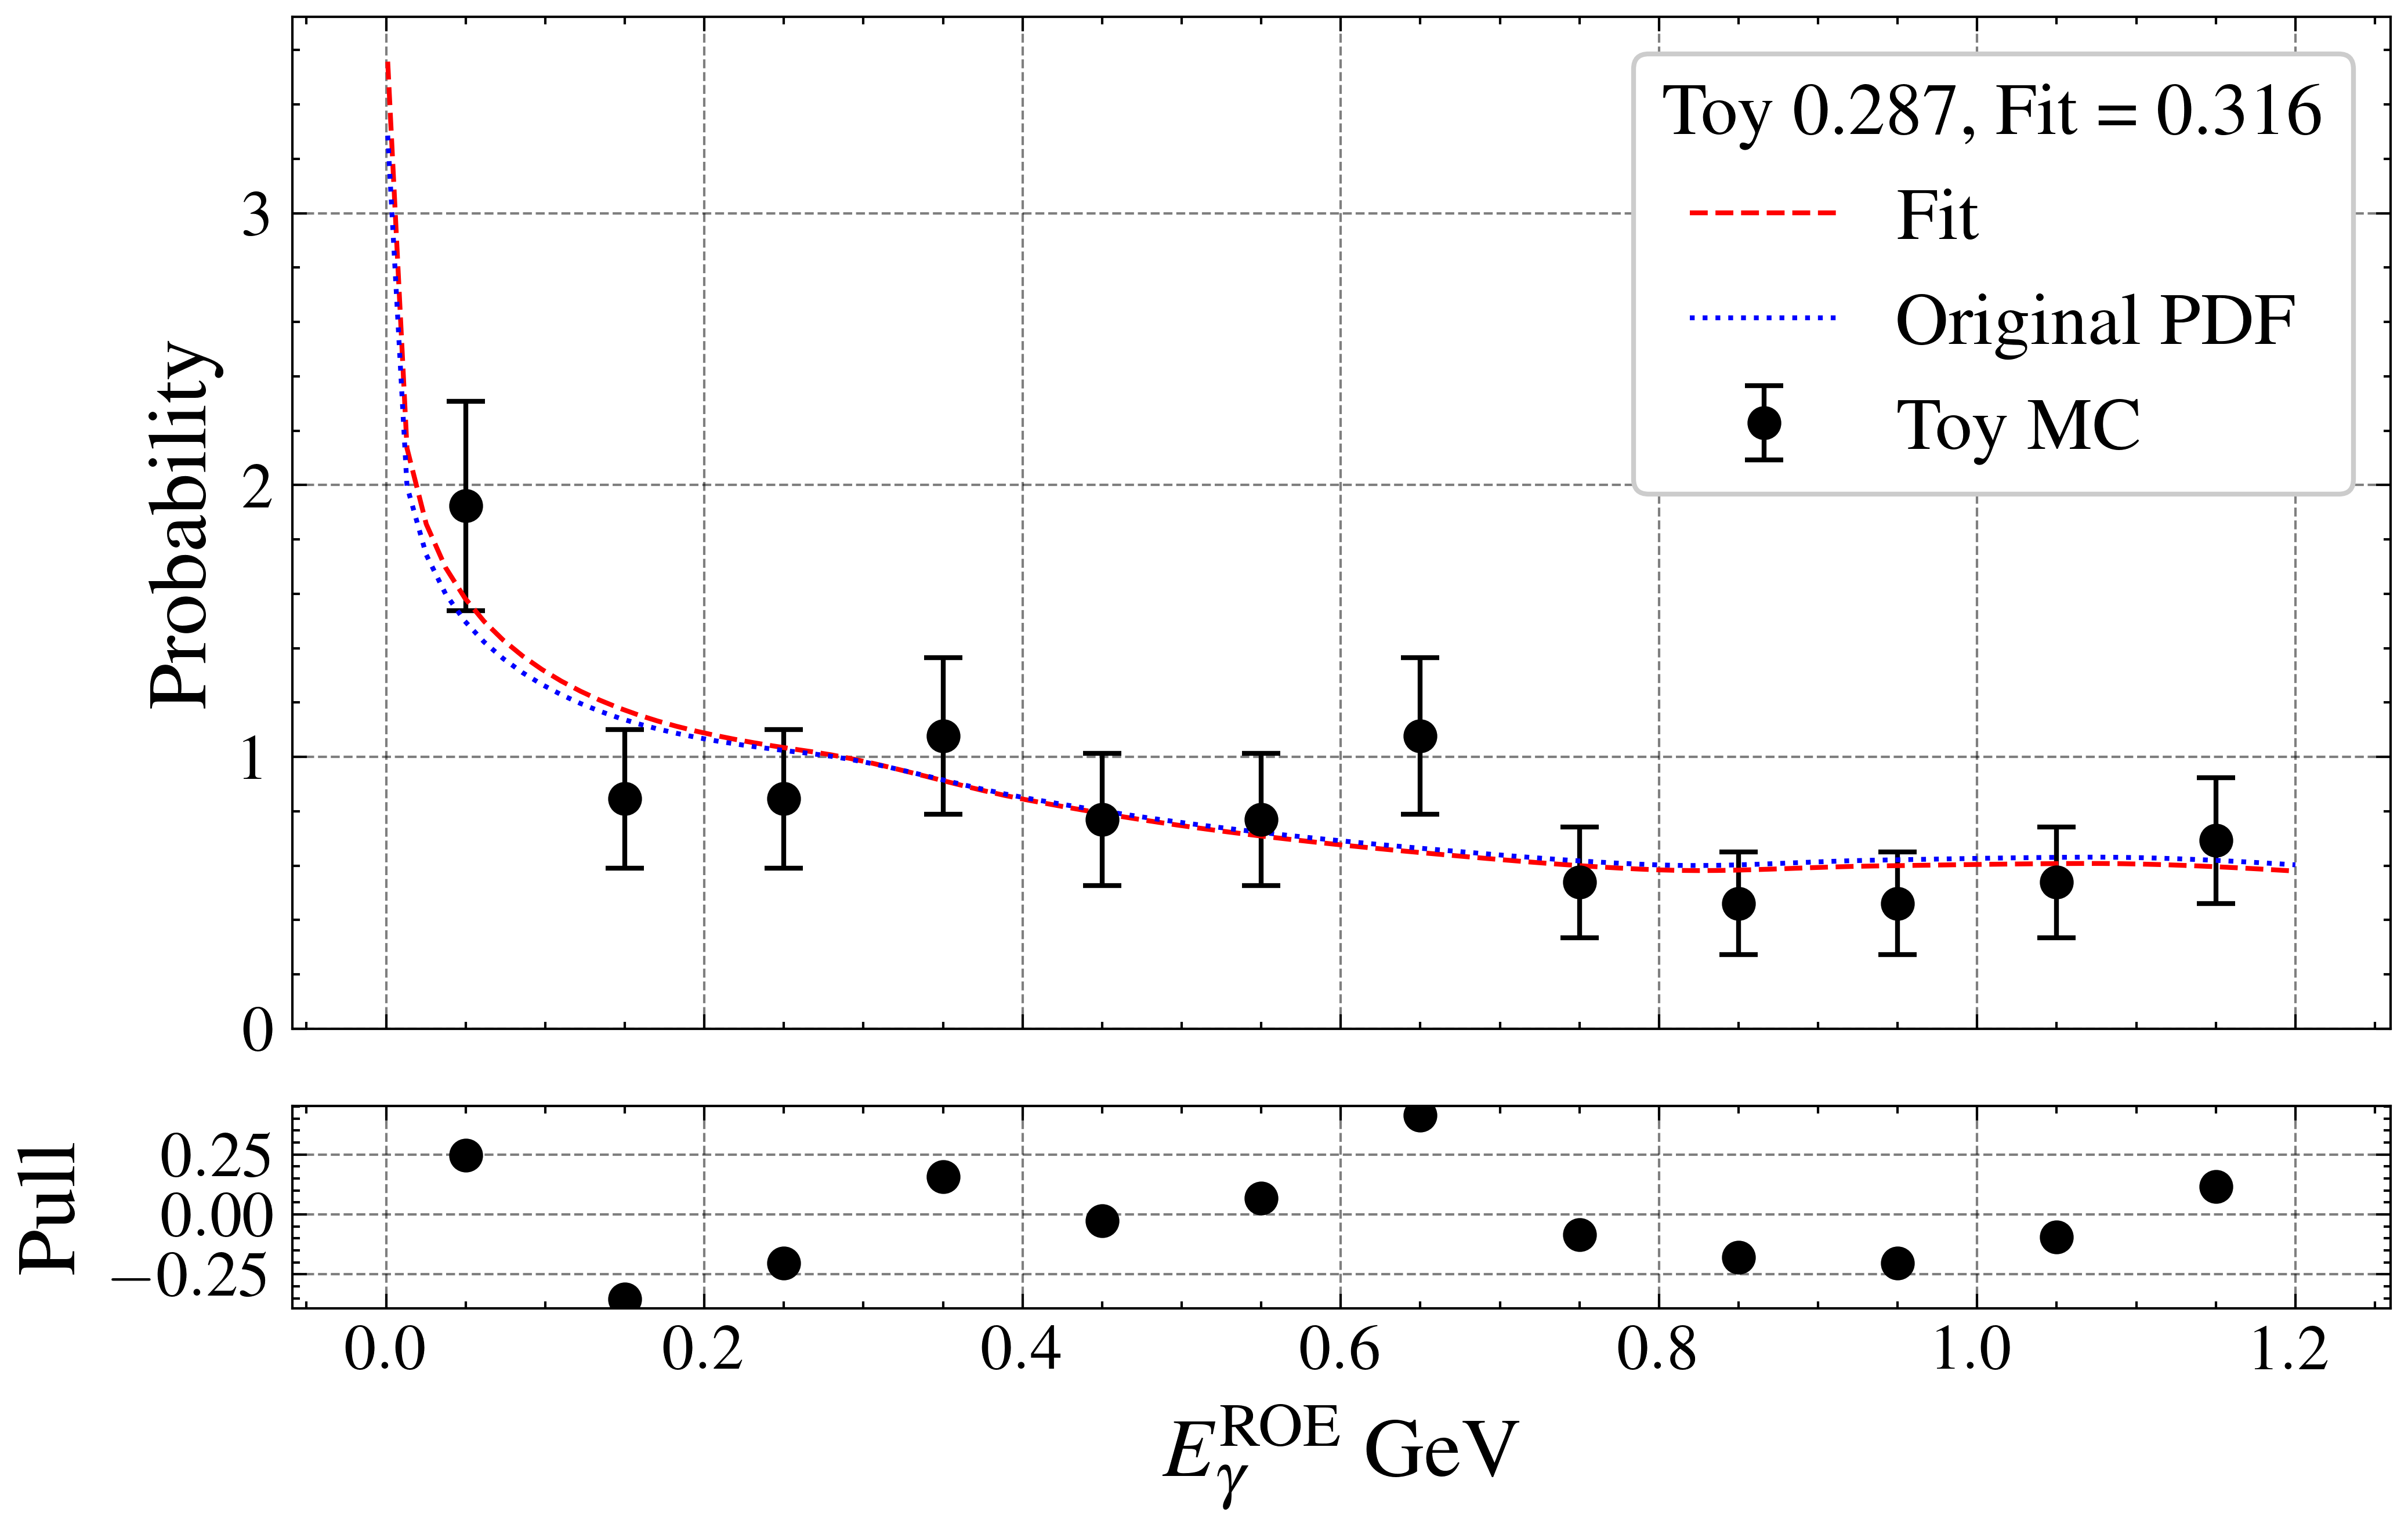

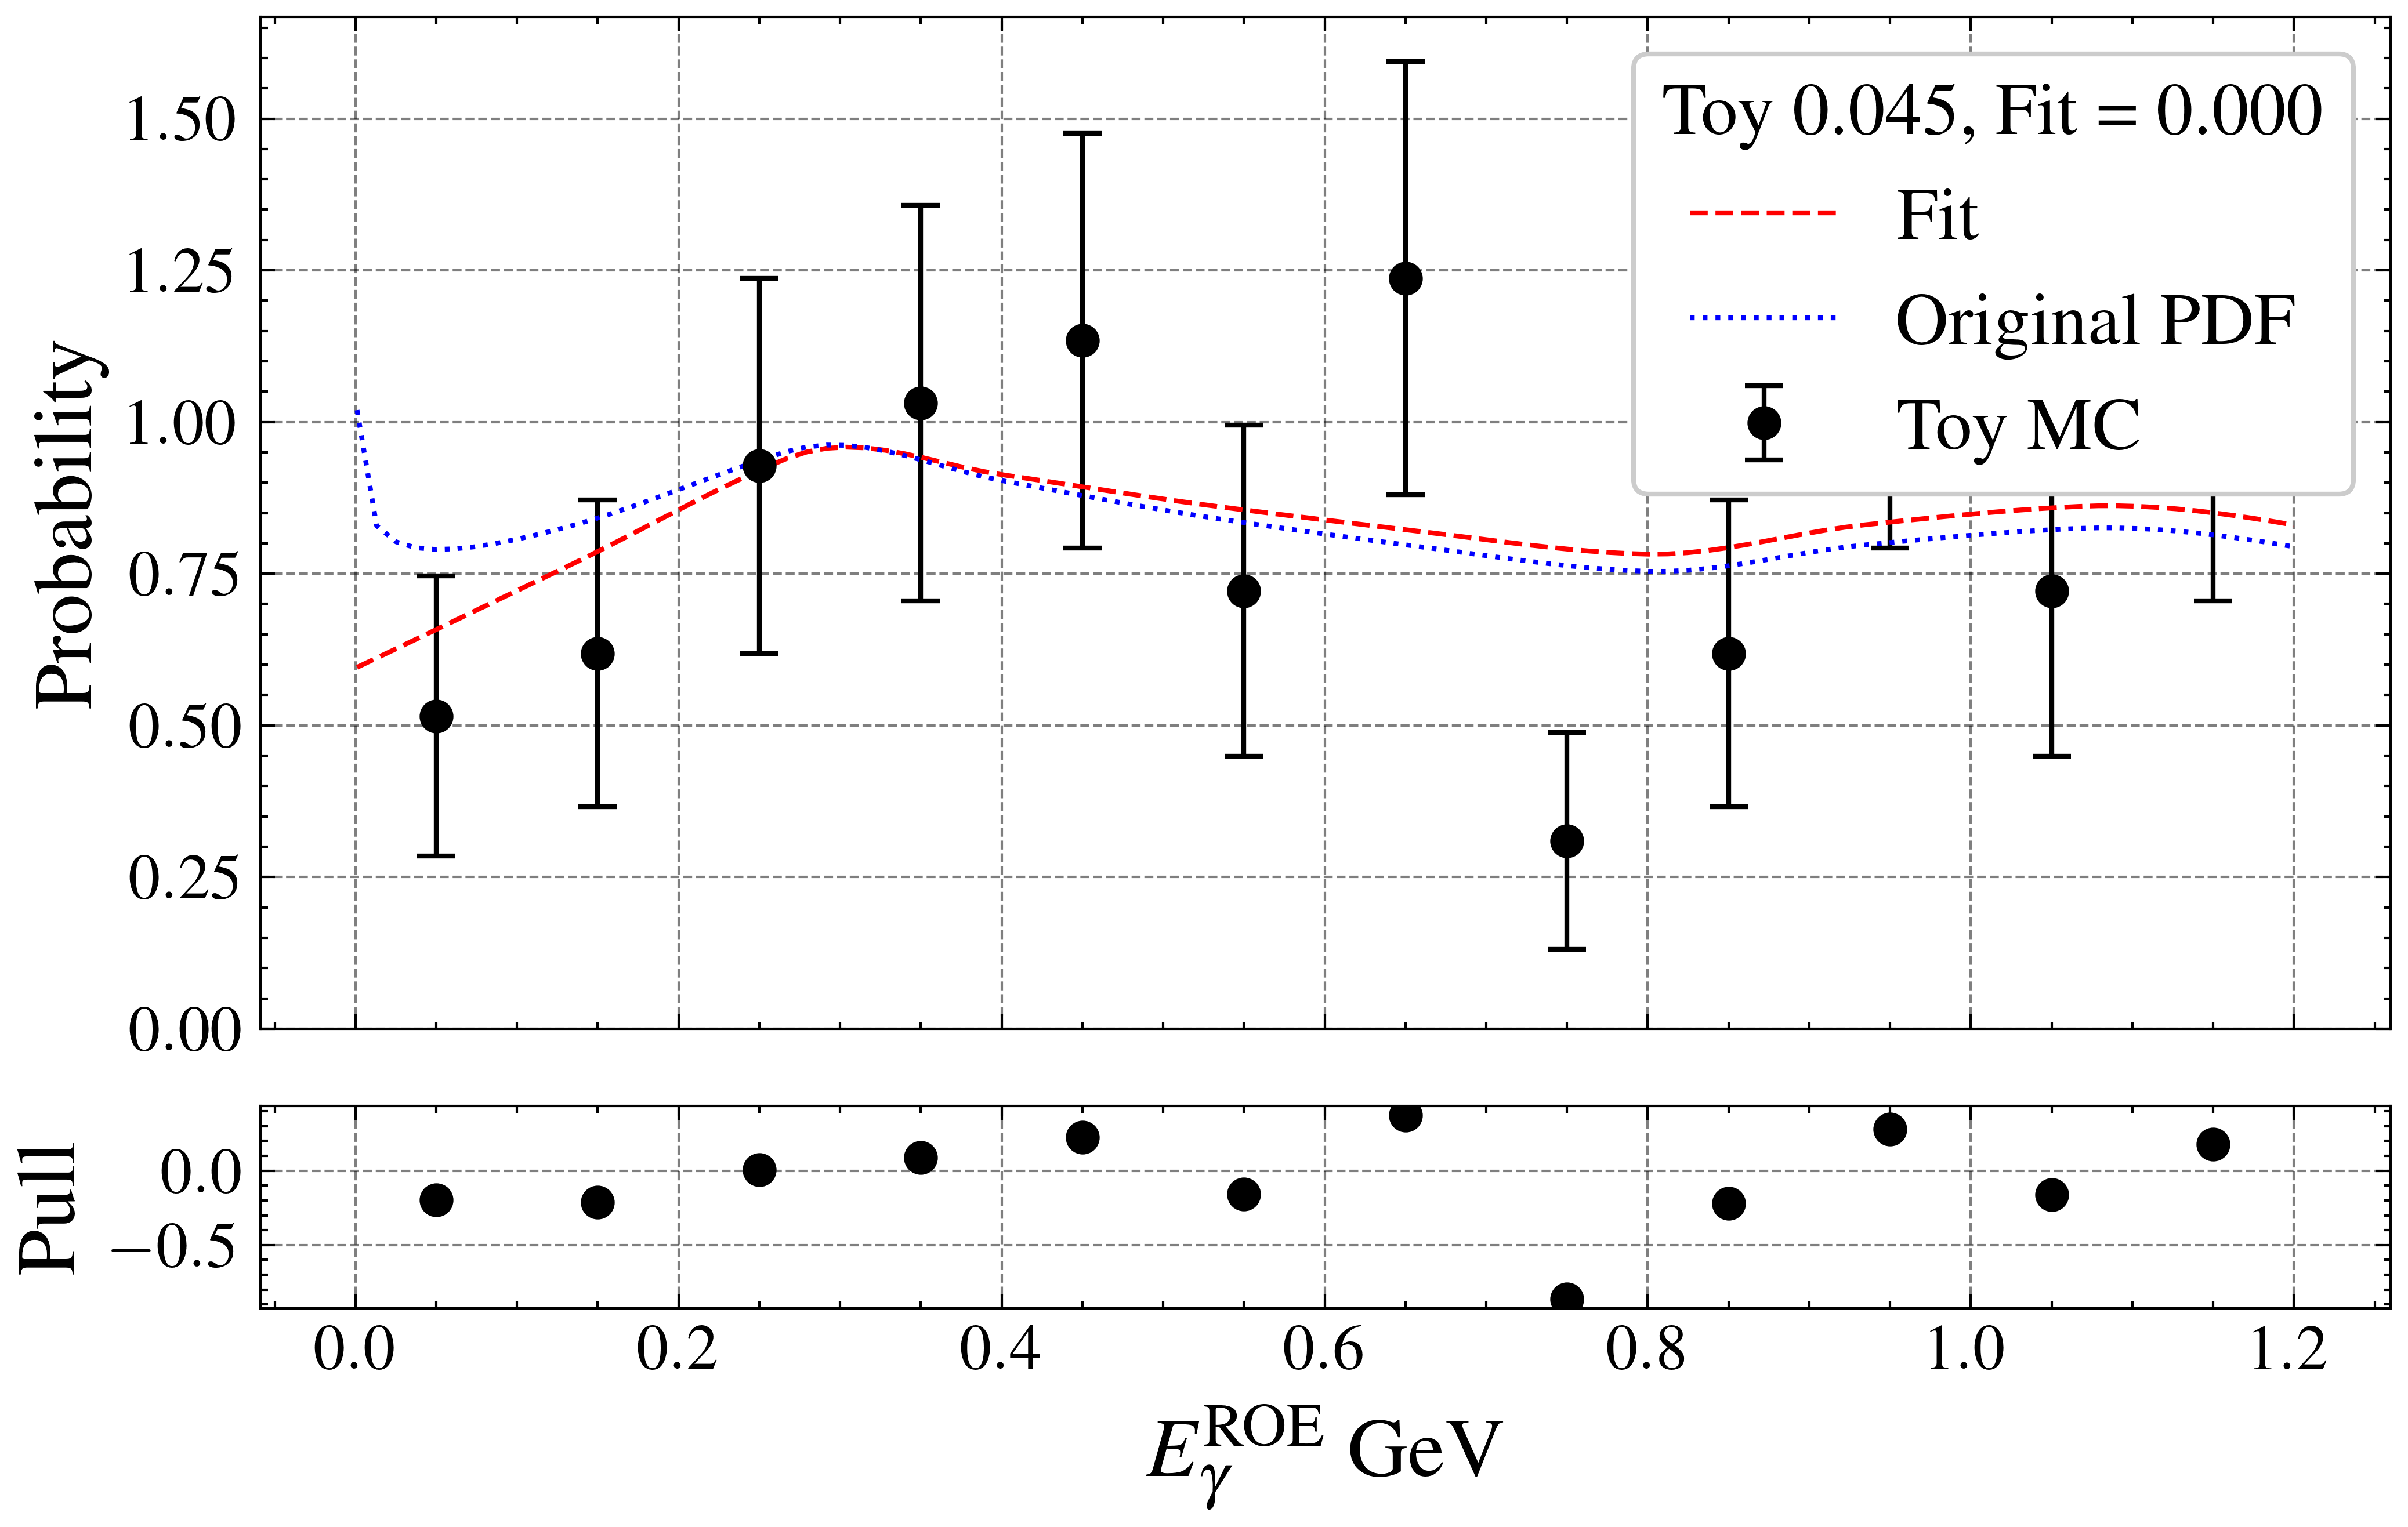

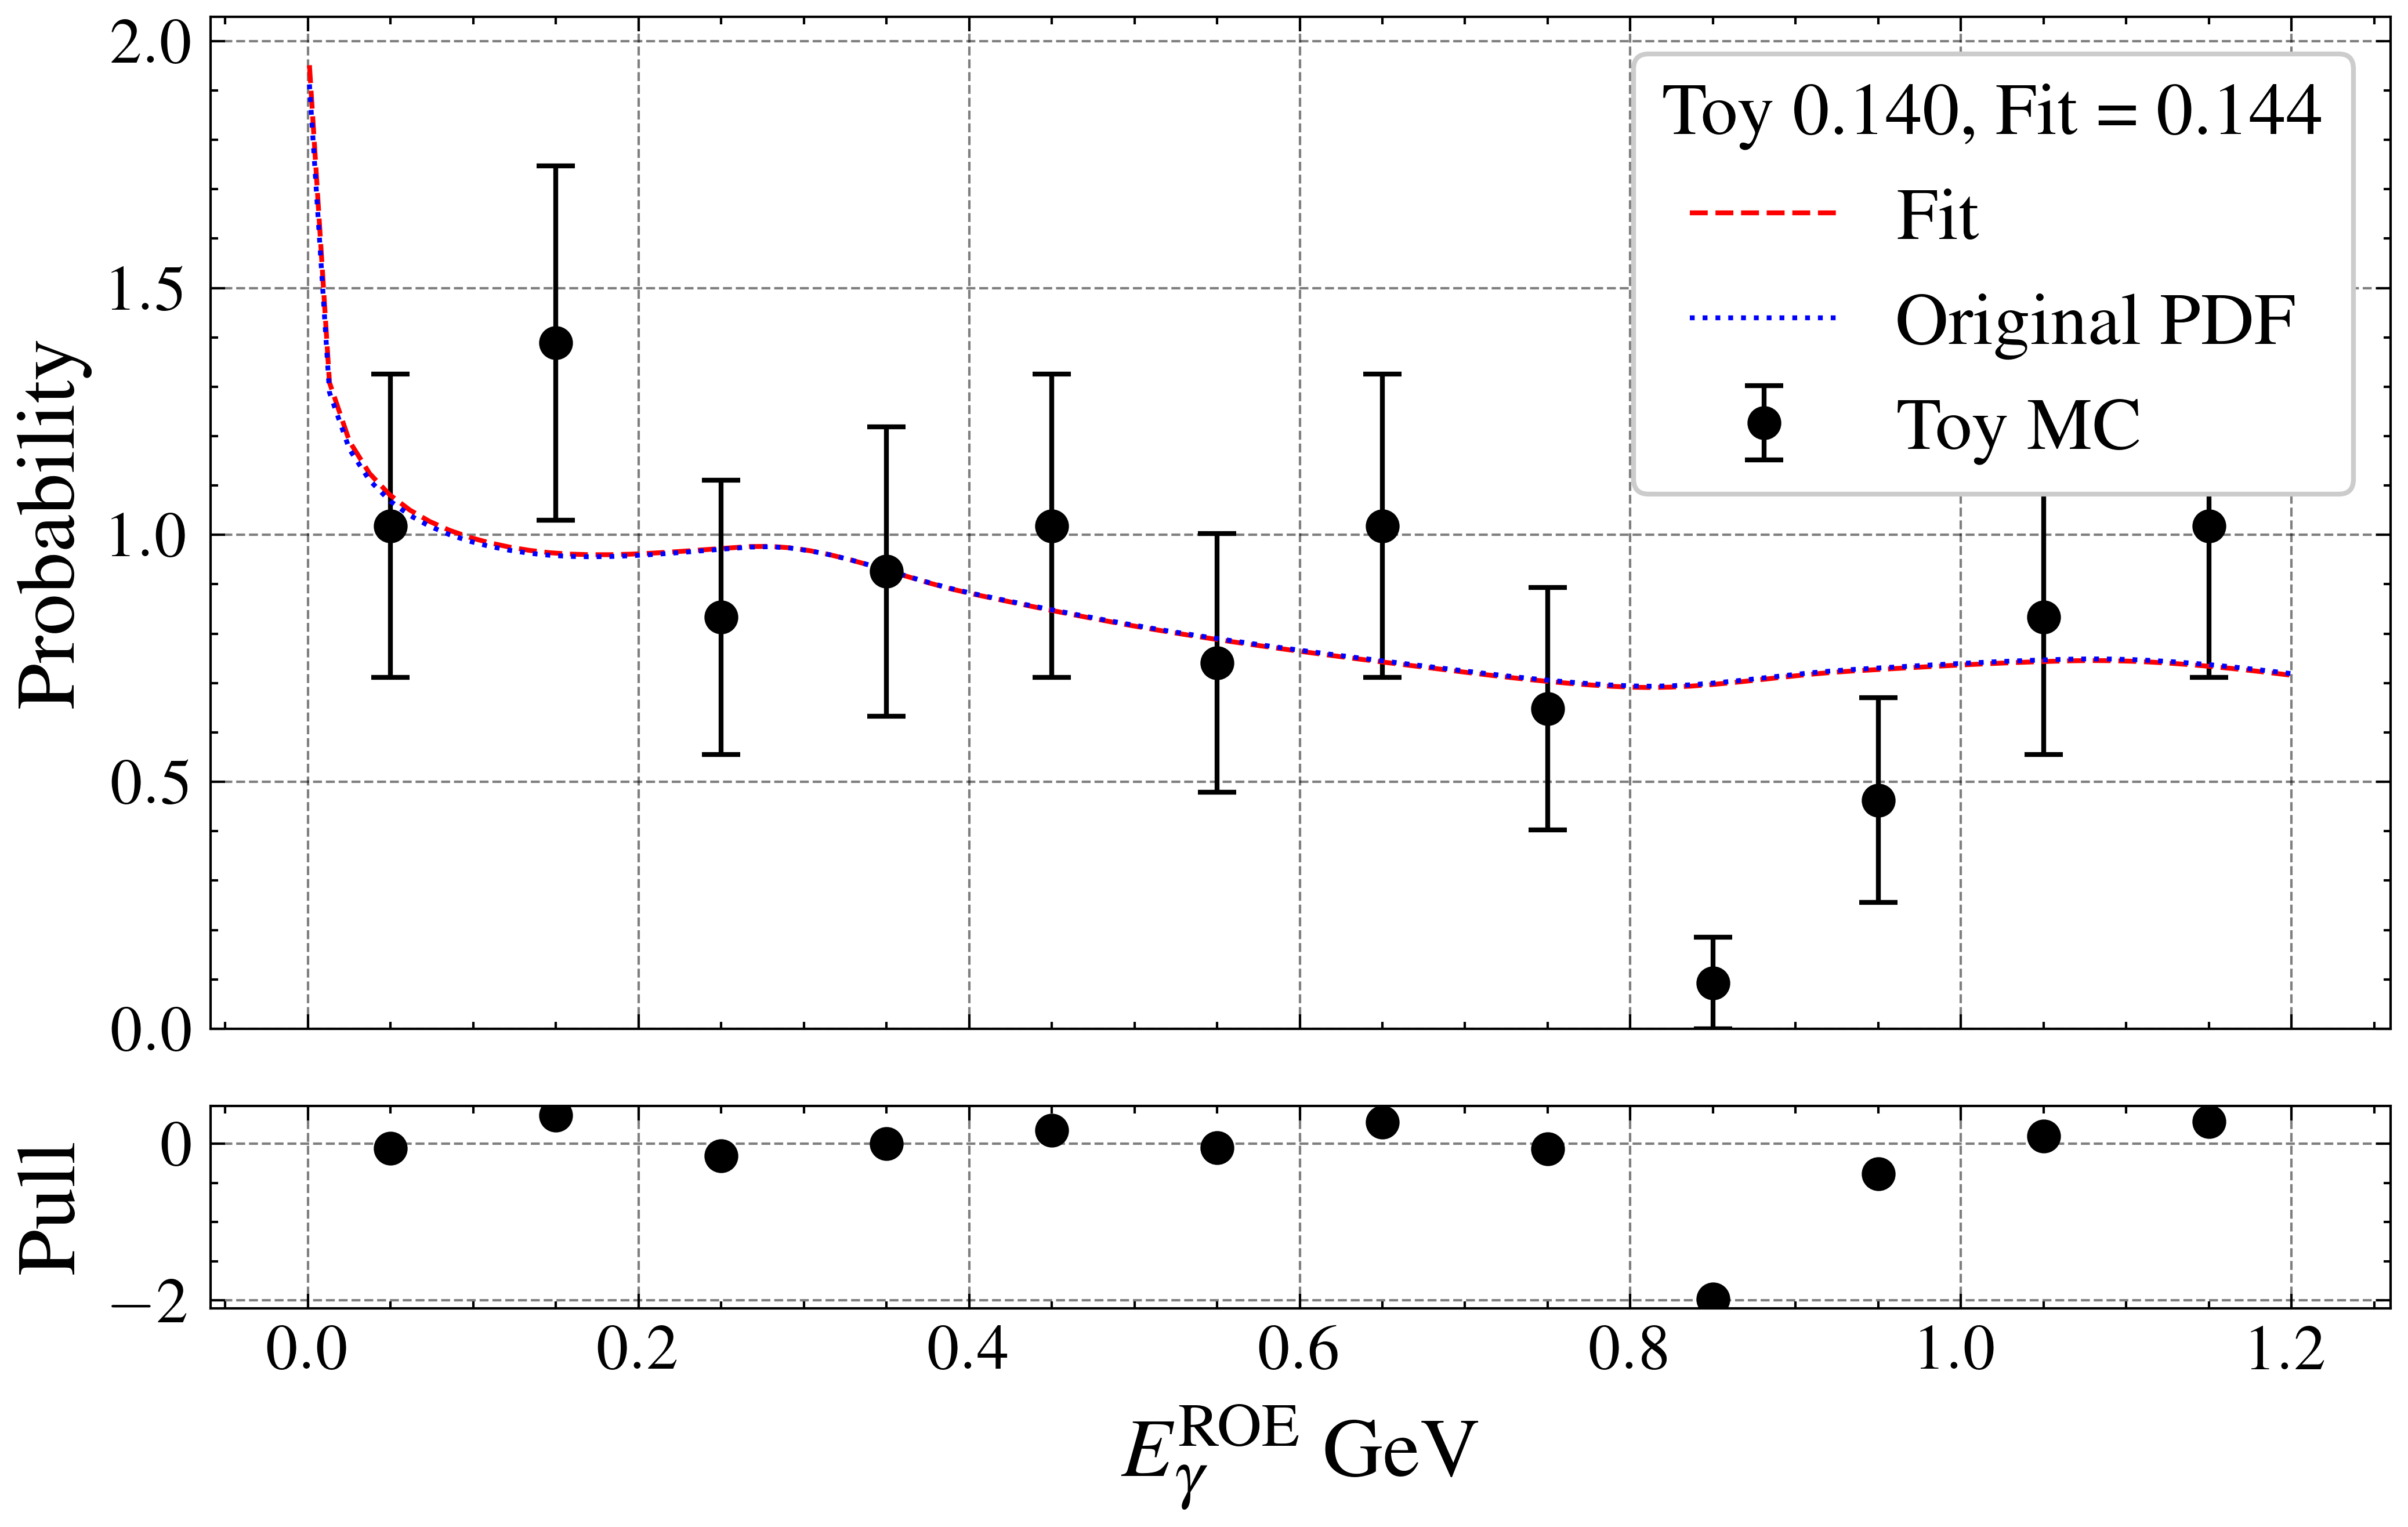

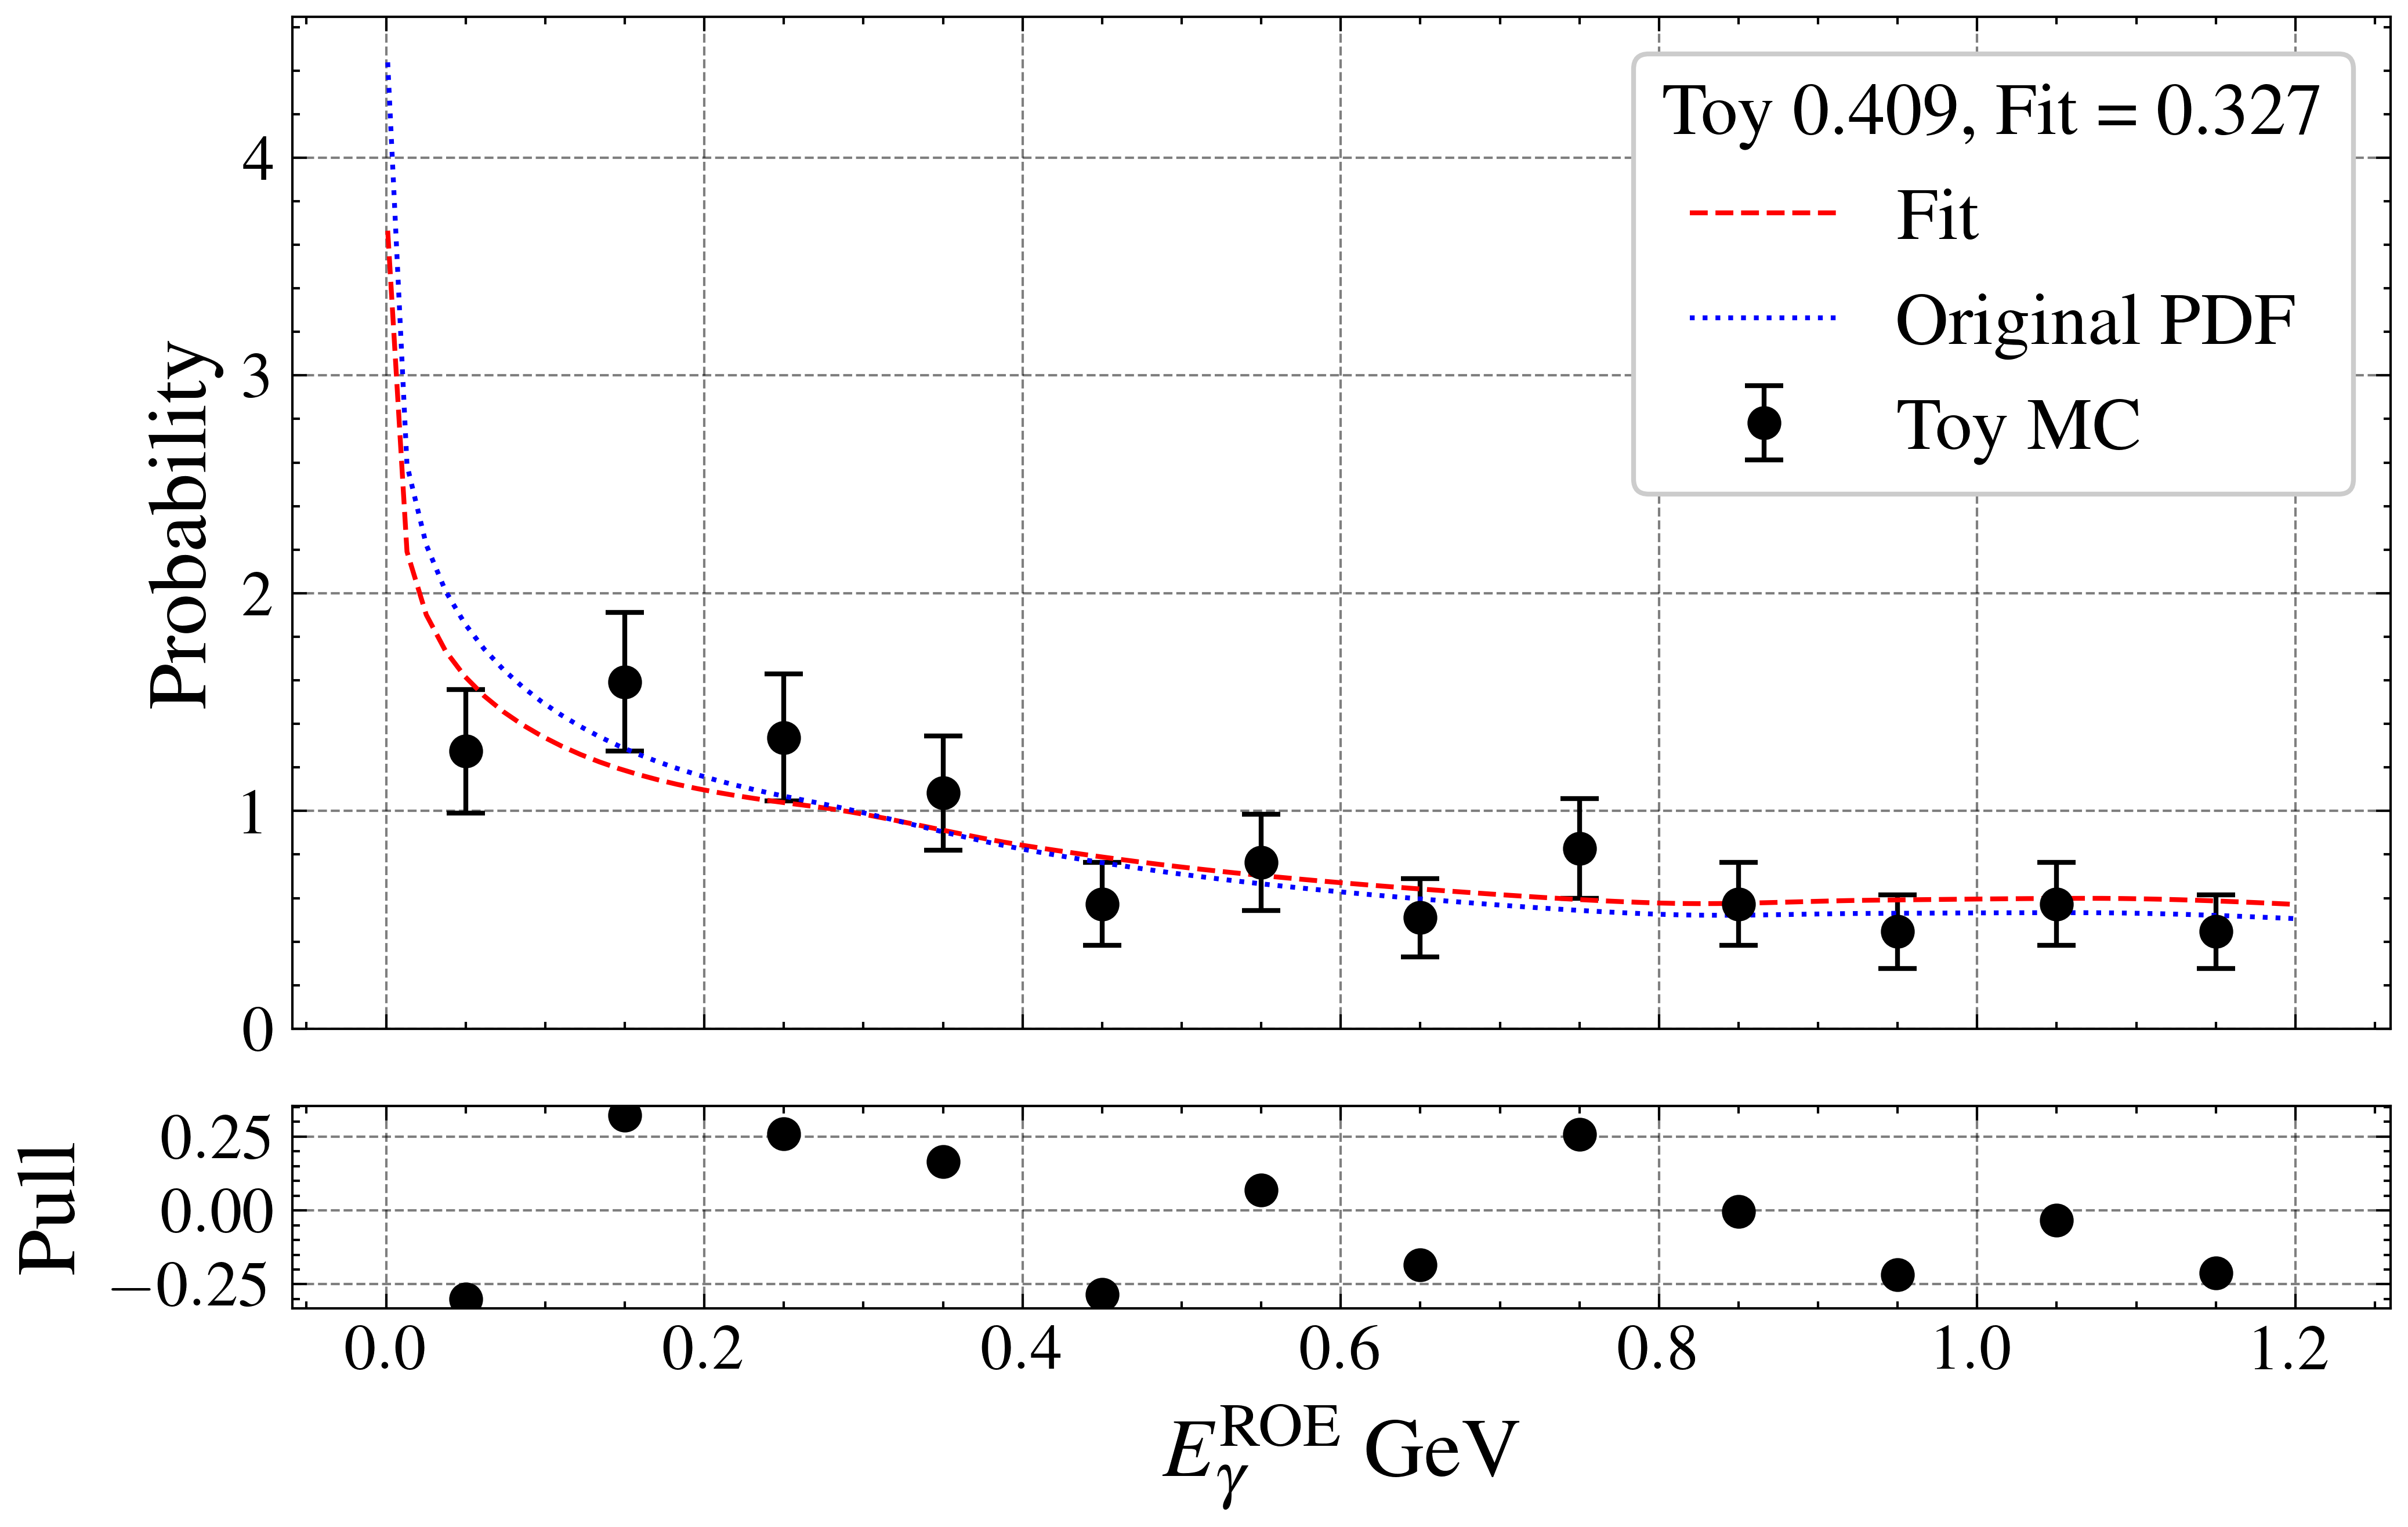

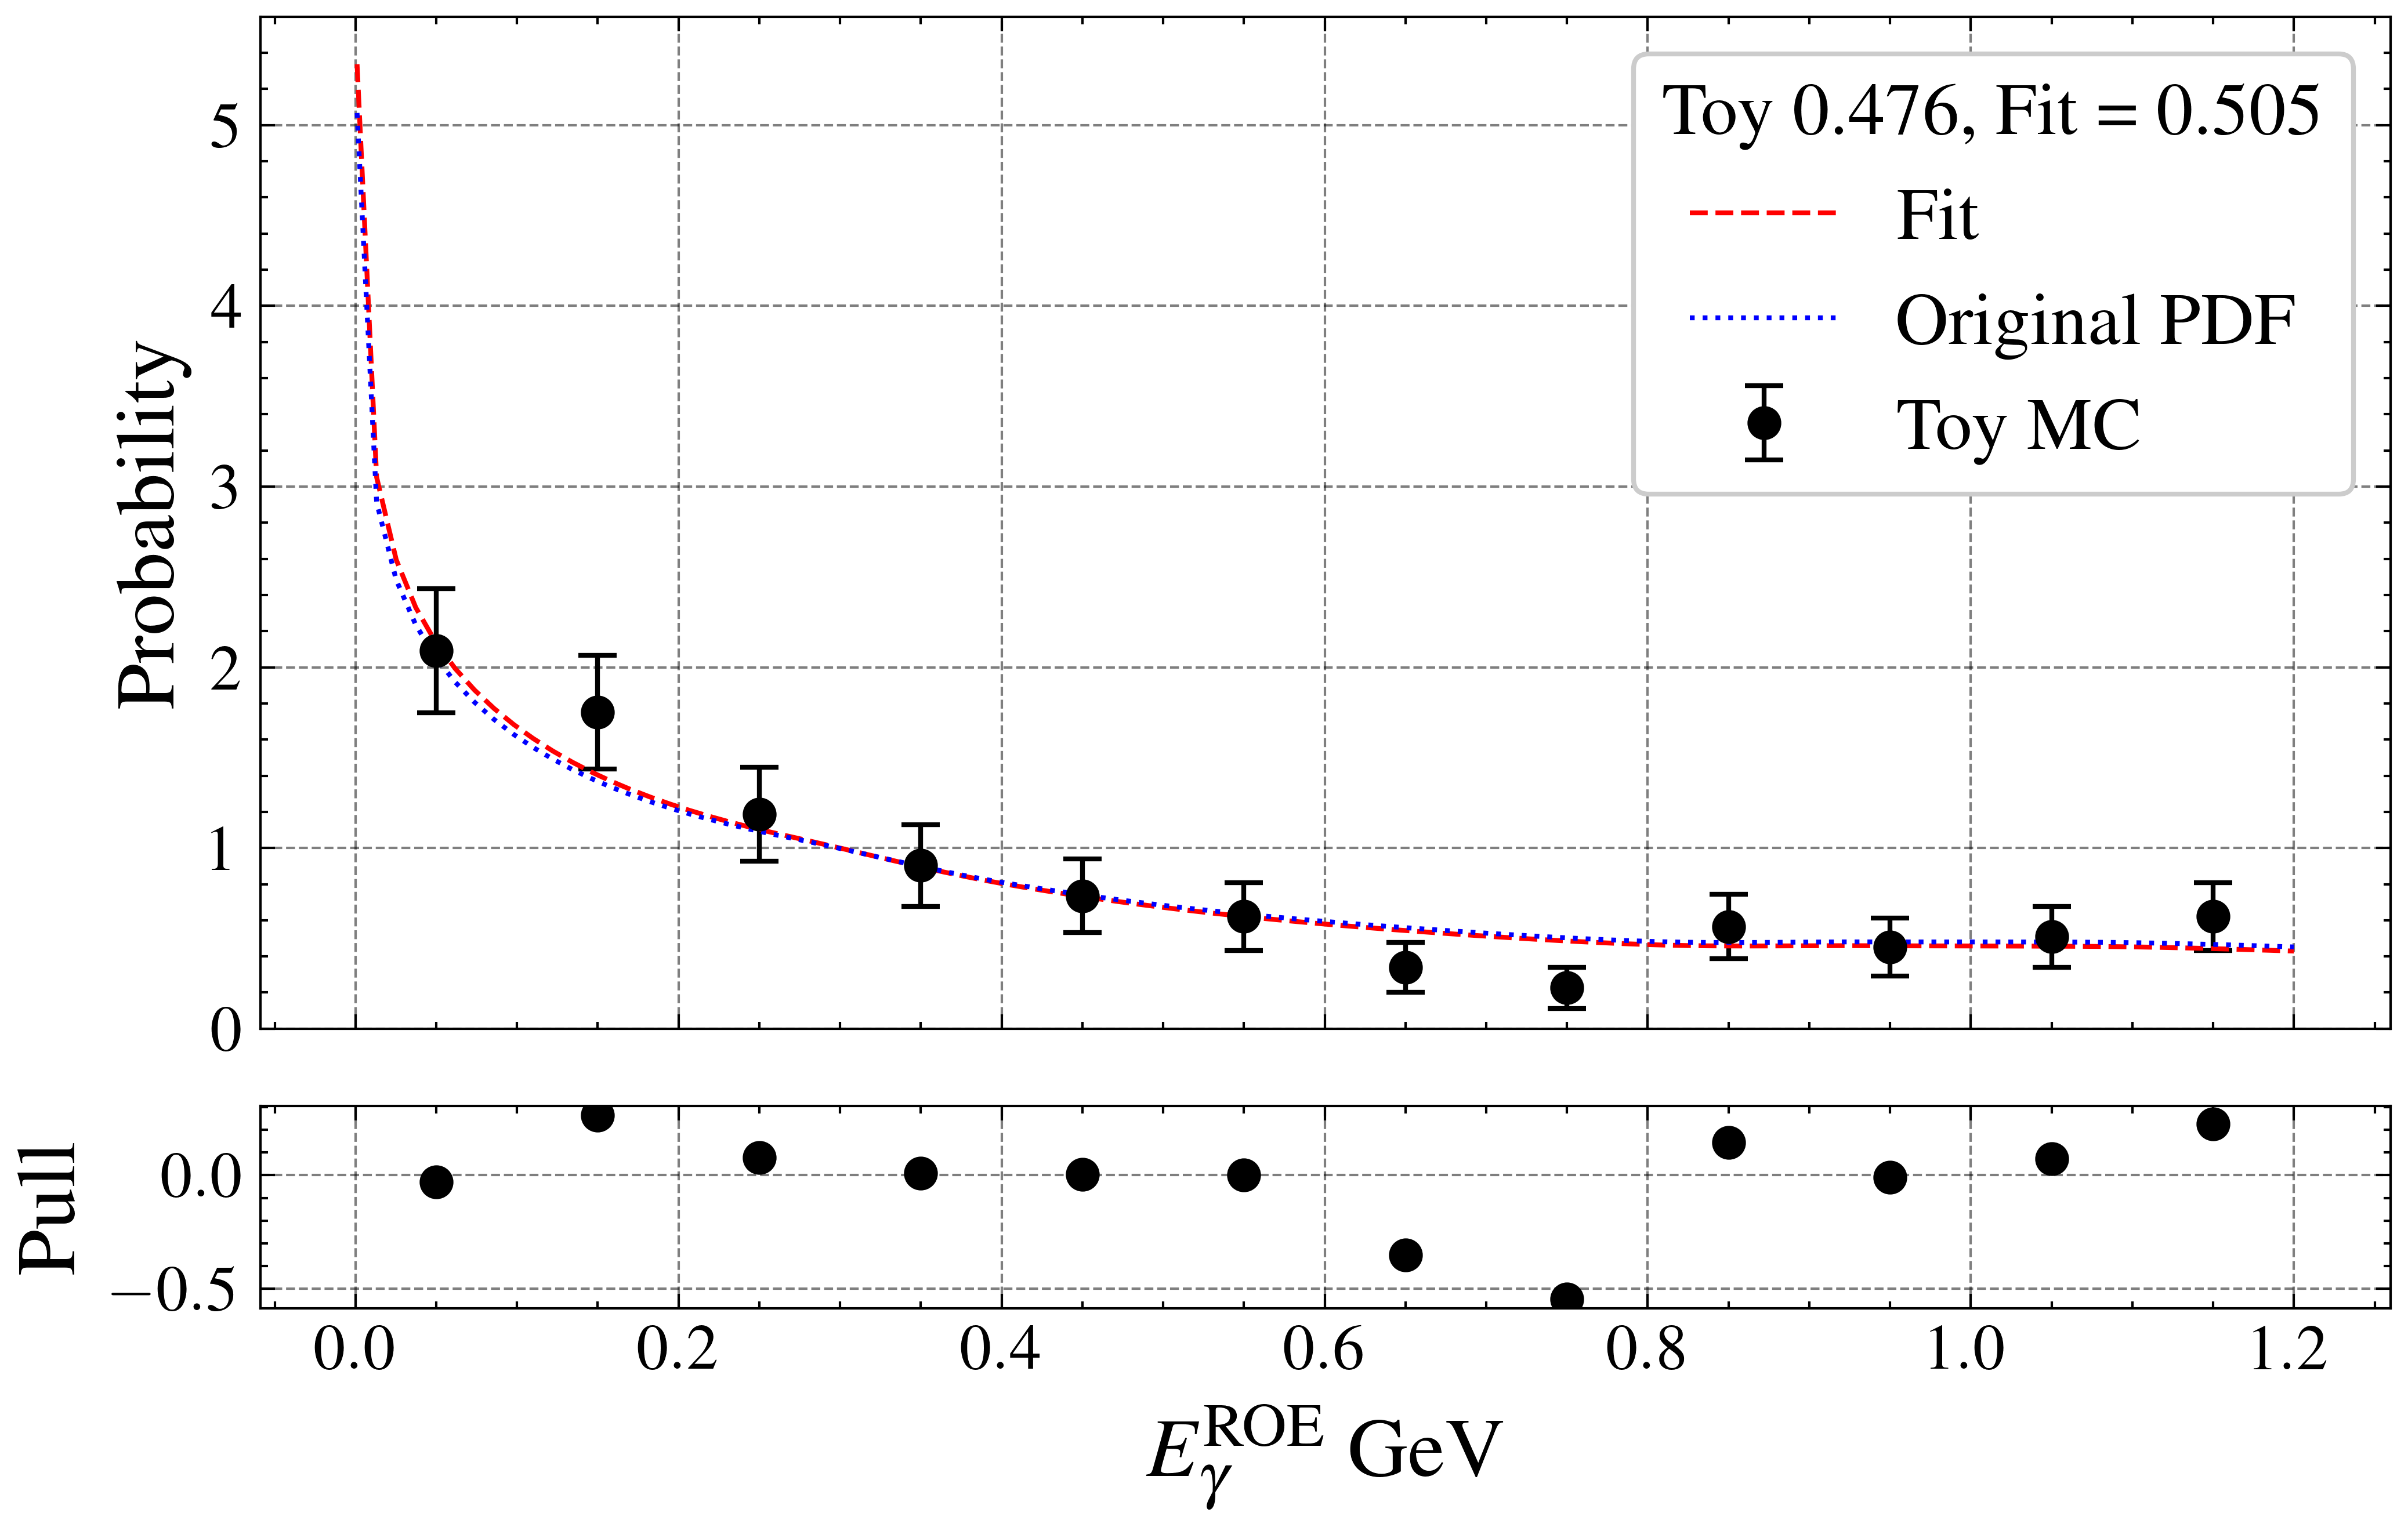

In [24]:

wbin = 0.1
a = 0
b = 1.2
bins = np.linspace(a, b, int((b-a)//wbin + 2))

plt_s = (12/1.7, 6/1.7)
pull_s = (12/6, 6/6)

n_toys = 5; i = 0
fit_results = []
A_list = []
while i < n_toys:   
    A = np.random.uniform(0, 1)

    toy_sample = np.concat([gen_toy(dg_pdf, a, b, size=N_bg/6), gen_toy(lambda x: f_E_g_lep_gamma(x, **rez0), a, b, size=int(N_bg/6*A))])

    rez = max_lik(f_fit, toy_sample, {"A" : 0.5,}, bounds={"A": (0, 1)})

    i += 1
    A_list.append(A/(1+A))
    fit_results.append(rez["A"])

    fig, axs = plt.subplots(2, 1, figsize=(plt_s[0], plt_s[1]+pull_s[1]), gridspec_kw={'height_ratios': [1, 0.2]}, sharex=True)
    
    ax = axs[0]
    counts, bin_centers = errorhist(toy_sample, bins=bins, err_func=np.sqrt, fmt='o', density=True, capsize=4, label="Toy MC", axs = ax)
    ax.plot(np.linspace(0.001, b, 100), f_fit(np.linspace(0.001, b, 100), **rez), label="Fit")
    ax.plot(np.linspace(0.001, b, 100), f_fit(np.linspace(0.001, b, 100), A = A/(1+A)), label="Original PDF")
    ax.set_ylabel("Probability")
    ax.legend(title =f"Toy {A/(1+A):.3f}, Fit = {rez['A']:.3f}")
    ax.set_ylim(0)

    ax_resid = axs[1]
    residuals = counts - f_fit(bin_centers, **rez)
    ax_resid.plot(bin_centers, residuals / np.sqrt(counts), 'o')
    ax_resid.set_xlabel(r'$E_{\gamma}^\mathrm{ROE} \ \mathrm{GeV}$')
    ax_resid.set_ylabel('$\\mathrm{Pull}$')
    ax_resid.set_xlim(ax.get_xlim()) 

    plt.tight_layout()

In [25]:

wbin = 0.1
a = 0
b = 1.2
bins = np.linspace(a, b, int((b-a)//wbin + 2))

n_toys = 1000; i = 0
fit_results = []
A_list = []
while i < n_toys:   
    A = np.random.uniform(0, 1)

    toy_sample = np.concat([gen_toy(dg_pdf, a, b, size=N_bg/6), gen_toy(lambda x: f_E_g_lep_gamma(x, **rez0), a, b, size=int(N_bg/6*A))])

    rez = max_lik(f_fit, toy_sample, {"A" : 0.5,}, bounds={"A": (0, 1)})

    i += 1
    A_list.append(A/(1+A))
    fit_results.append(rez["A"])


C:\Users\matve\AppData\Local\Temp\ipykernel_16024\2932709250.py:1: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  f_fit = lambda x, *, A: f_E_g_lep_gamma(x, **rez0)/np.trapz(f_E_g_lep_gamma(np.linspace(0, 1.2, 1000), **rez0), np.linspace(0, 1.2, 1000)) * np.abs(A) + dg_pdf(x) * np.abs(1 - A)


In [26]:
A_list = np.array(A_list)
fit_results = np.array(fit_results)

In [27]:
errors = fit_results - A_list
mean = np.mean(errors)
error_std = np.std(errors, ddof=1)

print(f"Error: {mean:.4f} +/- {error_std:.4f}")


Error: -0.0012 +/- 0.0572
